In [1]:
import torch
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data import random_split
from scipy.spatial.distance import directed_hausdorff
from augmentation import augment
from scipy.signal import stft, istft
from scipy.signal.windows import hann
import neurokit2 as nk
from models import Critic
from scipy.interpolate import interp1d

mps


WGAN
LSTM
2D Fourier Transform

In [2]:
torch.manual_seed(42)

In [3]:
num_subclasses = 300
epochs = 151
seq_size = 250
batch_size = 32
num_aug = 5
split_size=0.8
lr = 5e-4
input_channel = 4
output_channel = 1

In [4]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(int(num_subclasses), int(1000 / seq_size), seq_size, 12)
X = X.reshape(int(num_subclasses * int(1000 / seq_size)), seq_size, 12)
train_size = int(split_size*len(X))
test_size = len(X) - train_size
X,X_test = random_split(X,[train_size, test_size])
X = augment(X)
X_input = X[:, :, input_channel]  # First channel
Y_target = X[:, :, output_channel]  # Second channel


X_test_tensors = [X_test.dataset[idx] for idx in range(len(X_test))] 
X_test_tensor = torch.stack(X_test_tensors) 
X_t = X_test_tensor[:, :, 0]  
Y_t = X_test_tensor[:, :, output_channel]

In [5]:
def time_wrap(ecg_data):
    T, C = ecg_data.shape
    warp_factor = np.random.uniform(0.8, 1.2)  # Randomly stretch or compress

    # Create original time indices and new (warped) time indices
    original_time = np.linspace(0, 1, T)
    new_time = np.linspace(0, 1, int(T * warp_factor))

    warped = []
    for c in range(C):
        interp = interp1d(original_time, ecg_data[:, c], kind='linear', fill_value="extrapolate")
        warped_channel = interp(new_time)
        # Resize back to original length to maintain consistent shape
        if len(warped_channel) > T:
            warped_channel = warped_channel[:T]
        else:
            warped_channel = np.pad(warped_channel, (0, T - len(warped_channel)), mode='edge')
        warped.append(warped_channel)

    return np.stack(warped, axis=1)


def time_shifting(ecg_data):
    w = np.random.uniform(0.15, 0.45)
    if not (0 <= w <= 1):
        raise ValueError("w must be between 0 and 1.")
    T = ecg_data.shape[0]
    shift_length = int(w * T)
    # Perform a circular shift (rotation)
    ecg_data = np.roll(ecg_data, shift=shift_length, axis=0)
    return ecg_data
def add_noise(ecg_data):
    noise = np.random.normal(0, 0.005, ecg_data.shape)
    ecg_data += noise
    return ecg_data

def time_masking(ecg_data):
    w = np.random.uniform(0.05, 0.2)
    if not (0 <= w <= 1):
        raise ValueError("w must be between 0 and 1.")
    T = ecg_data.shape[0]
    mask_length = int(w * T)
    ts = np.random.randint(0, T - mask_length + 1)
    ecg_data[ts:ts + mask_length, :] = 0
    return ecg_data

In [6]:
def plotWave_aug(X, text):
    # If input is already numpy, no need for detach or cpu
    x_np = X.squeeze()

    plt.figure(figsize=(10, 4))
    plt.plot(x_np, label=text)
    plt.title("ECG Time Series Augmentation")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


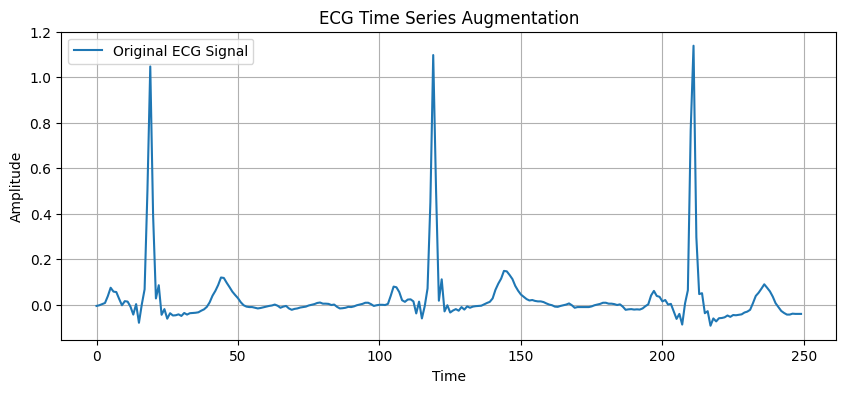

In [7]:
a = X[:,:, 2][0].detach().cpu().numpy()
plotWave_aug(a, "Original ECG Signal")

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, num_filters=32): 
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, 4, 2, 1),  
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters * 2, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters * 2, num_filters * 4, 4, 2, 1), 
            nn.BatchNorm1d(num_filters * 4),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(num_filters * 4, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )
        self.enc5 = nn.Sequential(
            nn.Conv1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )
        self.enc6 = nn.Sequential(
            nn.Conv1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 8, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 8),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 4, 4, 2, 1),  
            nn.BatchNorm1d(num_filters * 4),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 4, num_filters * 2, 4, 2, 1, output_padding=1),  # 63 → 125
            nn.BatchNorm1d(num_filters * 2),
            nn.ReLU()
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 2, num_filters, 4, 2, 1),
            nn.BatchNorm1d(num_filters),
            nn.ReLU()
        )
        self.dec6 = nn.ConvTranspose1d(num_filters, out_channels, 4, 2, 1)  
        self.final_activation = nn.LeakyReLU(0.2)  

    def match_size(self, x, target):
        diff = x.size(2) - target.size(2)
        if diff > 0:
            return x[:, :, :-diff]
        elif diff < 0:
            return nn.functional.pad(x, (0, -diff))
        else:
            return x

    def forward(self, x):
        # x shape: (batch_size, 2, seq_len)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)

        d1 = self.match_size(self.dec1(e6), e5) + e5
        d2 = self.match_size(self.dec2(d1), e4) + e4
        d3 = self.match_size(self.dec3(d2), e3) + e3
        d4 = self.match_size(self.dec4(d3), e2) + e2
        d5 = self.match_size(self.dec5(d4), e1) + e1
        d6 = self.dec6(d5)
        return self.final_activation(d6)

In [9]:
class LSTMGenerator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, num_filters=32):
        super(LSTMGenerator, self).__init__()
        self.seq_size = seq_size

        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, 4, 2, 1),  # 250 → 125
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters * 2, 4, 2, 1),  # 125 → 63
            nn.BatchNorm1d(num_filters * 2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters * 2, num_filters * 4, 4, 2, 1),  # 63 → 32
            nn.BatchNorm1d(num_filters * 4),
            nn.LeakyReLU(0.2)
        )

        self.lstm = nn.LSTM(num_filters * 4, num_filters * 4, batch_first=True)

        self.flatten = nn.Flatten()

        # Output layer maps to (out_channels * seq_size) = 1 * 250 = 250
        self.output_layer = nn.Linear(3968, out_channels * seq_size)
        self.final_activation = nn.Tanh()

    def forward(self, x):
        e1 = self.enc1(x)                        # [32, 32, 125]
        e2 = self.enc2(e1)                       # [32, 64, 63]
        e3 = self.enc3(e2)                       # [32, 128, 32]

        lstm_input = e3.transpose(1, 2)          # [32, 32, 128]
        lstm_out, _ = self.lstm(lstm_input)      # [32, 32, 128]

        lstm_out = self.flatten(lstm_out)        # [32, 32*128]

        output = self.output_layer(lstm_out)     # [32, 250]

        output = output.view(-1, 1, self.seq_size)  # [32, 1, 250]
        return self.final_activation(output)


In [10]:
# x = real_2[0].cpu().numpy()

# nperseg = 30
# noverlap = 6
# window = hann(nperseg)
# f, t, Zxx = stft(x, window=window, nperseg=nperseg, noverlap=noverlap,
#                  boundary=None, padded=False)

# real_part = np.real(Zxx)
# imag_part = np.imag(Zxx)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# im0 = axs[0].imshow(real_part, origin='lower', aspect='auto', cmap='plasma')
# axs[0].set_title('Real Part of STFT')
# axs[0].set_xlabel('Time Frames')
# axs[0].set_ylabel('Frequency Bins')
# plt.colorbar(im0, ax=axs[0])
# im1 = axs[1].imshow(imag_part, origin='lower', aspect='auto', cmap='plasma')
# axs[1].set_title('Imaginary Part of STFT')
# axs[1].set_xlabel('Time Frames')
# axs[1].set_ylabel('Frequency Bins')
# plt.colorbar(im1, ax=axs[1])

# plt.tight_layout()
# plt.show()


# _, x_reconstructed = istft(Zxx, window=window, nperseg=nperseg, noverlap=noverlap,
#                            input_onesided=True, boundary=None)

# x_reconstructed = x_reconstructed[:len(x)]
# plt.figure(figsize=(12, 4))
# plt.plot(x, label='Original Signal', alpha=0.7)
# plt.plot(x_reconstructed, '--', label='Reconstructed Signal (iSTFT)', alpha=0.7)
# plt.title("Comparison of Original and Reconstructed Signals")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [11]:
class Discriminator(nn.Module):
    def __init__(self, seq_size, num_filters=32):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=num_filters, kernel_size=4, stride=2, padding=1)
        self.leakyRelu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(num_filters, num_filters*2, 4, 2, 1)
        self.bn1 = nn.BatchNorm1d(num_filters*2)
        self.conv3 = nn.Conv1d(num_filters*2, num_filters*4, 4, 2, 1)
        self.bn2 = nn.BatchNorm1d(num_filters*4)
        self.conv4 = nn.Conv1d(num_filters*4, num_filters*8, 4, 2, 1)
        self.bn3 = nn.BatchNorm1d(num_filters*8)
        self.conv5 = nn.Conv1d(num_filters*8, num_filters*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm1d(num_filters*8)
        self.conv6 = nn.Conv1d(num_filters*8, 1, 4, 2, 1)
        self.op = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyRelu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leakyRelu(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leakyRelu(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = self.leakyRelu(x)
        x = self.conv6(x)
        x = self.leakyRelu(x)
        x = x.view(x.size(0), -1)  
        x = self.op(x)
        x = self.sigmoid(x)
        return x

In [12]:
dataset = TensorDataset(X_input, Y_target)
test_dataset = TensorDataset(X_t, Y_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
generator = Generator().to(device)
#discriminator = Discriminator(seq_size).to(device)
critic  = Critic(seq_size).to(device)
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005)
#optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
optimizer_c = torch.optim.AdamW(critic.parameters(), lr=0.0001)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
#print(sum(p.numel() for p in discriminator.parameters())/1e6, 'M parameters for Discriminator')
print(sum(p.numel() for p in critic.parameters())/1e6, 'M parameters for Critic')

1.398145 M parameters for Generator
0.216097 M parameters for Critic


In [13]:
def plot_losses(d_losses, g_losses):
    def smooth_curve(points, factor=0.9):
        smoothed = []
        for point in points:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + point * (1 - factor))
            else:
                smoothed.append(point)
        return smoothed

    plt.plot(smooth_curve(d_losses), label='D Loss')
    plt.plot(smooth_curve(g_losses), label='G Loss')
    plt.legend()
    plt.show()

In [14]:
counter = 0
def plotWave(X, Y, c=0):
    x_np = X.squeeze(0).detach().cpu().numpy()
    y_np = Y.squeeze(0).detach().cpu().numpy()

    # Plotting
    plt.figure(figsize=(20, 6))
    plt.plot(x_np, color='blue', label='X (Generated Signal)')
    plt.plot(y_np, color='red', label='Y (Real Signal)')
    plt.legend()
    plt.title(f'Wave Comparison - Frame {c}')
    plt.show()

    # MSE
    mse = np.mean((x_np - y_np) ** 2)
    # FD
    fd = max(directed_hausdorff(x_np.reshape(-1, 1), y_np.reshape(-1, 1))[0],
             directed_hausdorff(y_np.reshape(-1, 1), x_np.reshape(-1, 1))[0])

    print(f"Frame {c}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Fréchet Distance: {fd:.4f}")

    return c + 1


In [15]:
def l1_loss(x,y):
    return torch.mean(torch.abs(x - y))

In [16]:
def compute_gradient_penalty(critic, real_samples, fake_samples, real_1, device):
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    critic_input = torch.cat([interpolates, real_1], dim=1)
    critic_interpolates = critic(critic_input)
    grad_outputs = torch.ones_like(critic_interpolates).to(device)
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=critic_input,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

Epoch 1/151, Critic Loss: -0.12281128019094467, Generator Loss: -4.0686492919921875
Epoch 2/151, Critic Loss: 0.15401624143123627, Generator Loss: -3.6097471714019775
Epoch 3/151, Critic Loss: -0.3945513963699341, Generator Loss: -2.7823214530944824
Epoch 4/151, Critic Loss: 0.9840115904808044, Generator Loss: -7.682081699371338
Epoch 5/151, Critic Loss: -1.5936447381973267, Generator Loss: -1.5532090663909912
Epoch 6/151, Critic Loss: -0.5535663962364197, Generator Loss: -6.509912014007568
Epoch 7/151, Critic Loss: 0.7440162897109985, Generator Loss: -3.1615071296691895
Epoch 8/151, Critic Loss: -0.057399798184633255, Generator Loss: -2.2627110481262207
Epoch 9/151, Critic Loss: -1.3333766460418701, Generator Loss: -4.756596565246582


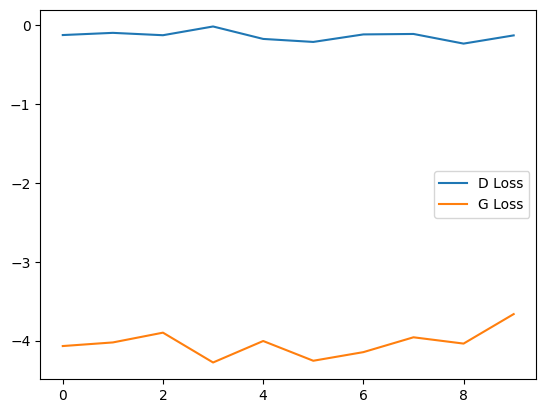

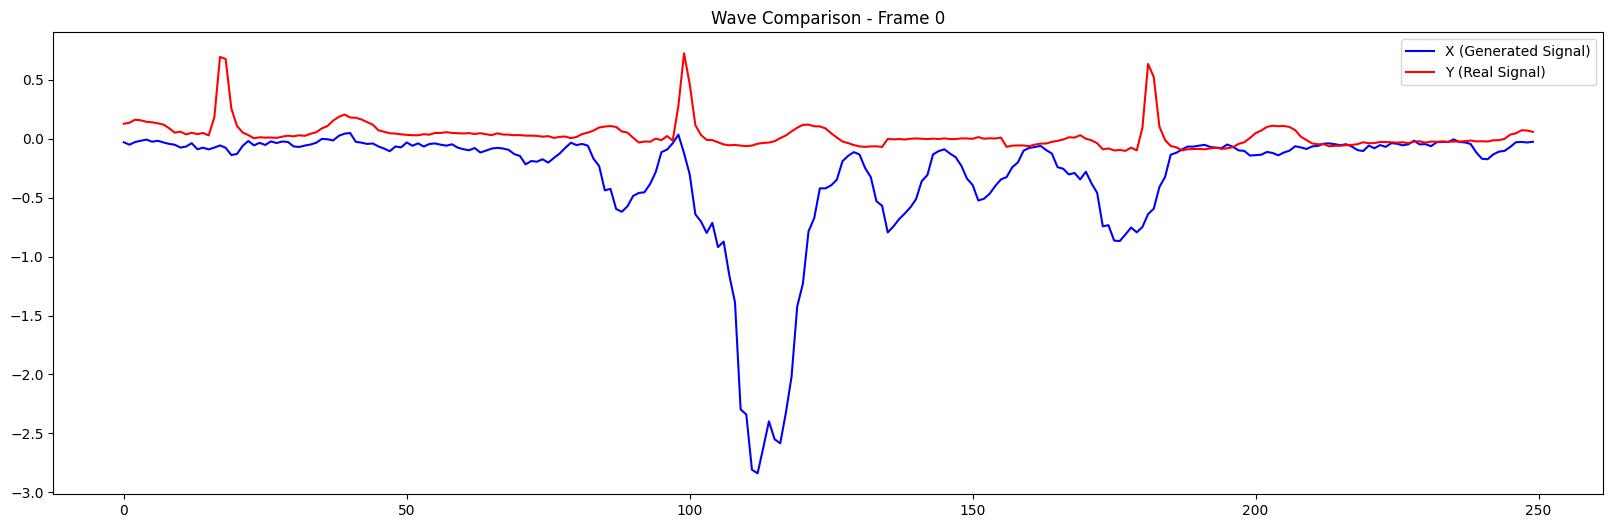

Frame 0:
Mean Squared Error (MSE): 0.3790
Fréchet Distance: 2.7337


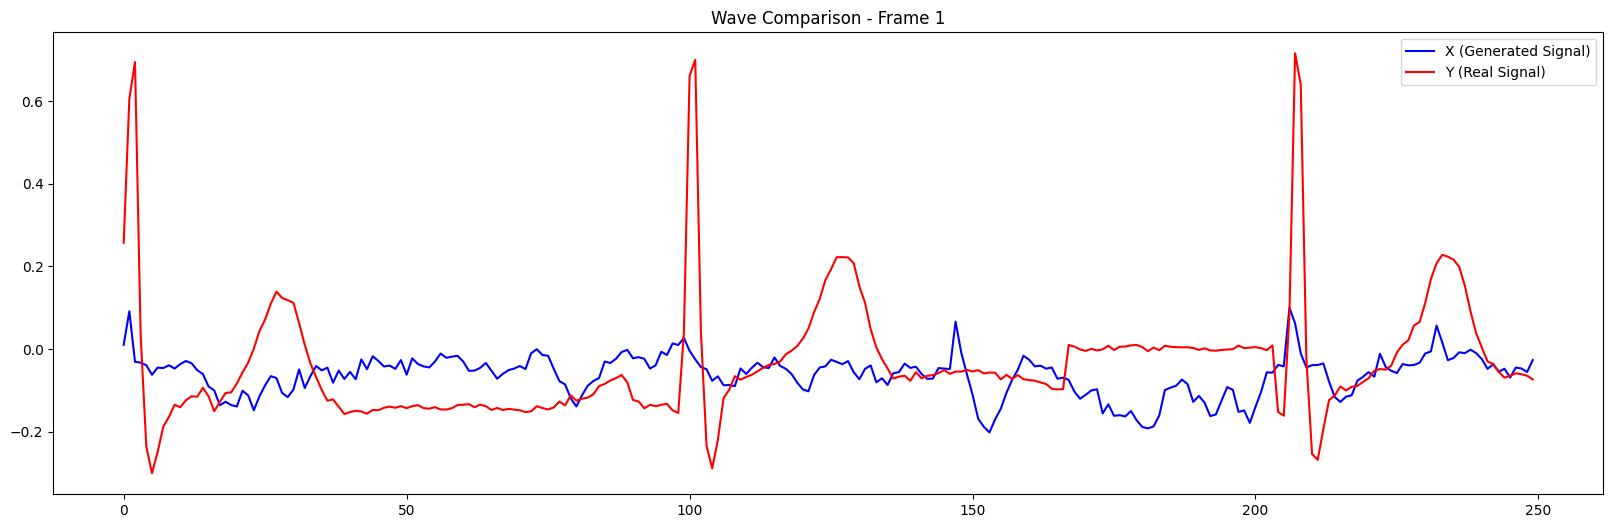

Frame 1:
Mean Squared Error (MSE): 0.0232
Fréchet Distance: 0.6165
Epoch 10/151, Critic Loss: 0.8116281032562256, Generator Loss: -0.2935328781604767
Epoch 11/151, Critic Loss: -0.21180525422096252, Generator Loss: -0.817786455154419
Epoch 12/151, Critic Loss: -0.9046328663825989, Generator Loss: -3.154348850250244
Epoch 13/151, Critic Loss: 0.8685327172279358, Generator Loss: -4.3225884437561035
Epoch 14/151, Critic Loss: 0.6934685111045837, Generator Loss: -3.4561386108398438
Epoch 15/151, Critic Loss: -0.3353096842765808, Generator Loss: -2.345247745513916
Epoch 16/151, Critic Loss: 0.2838677167892456, Generator Loss: 0.30930736660957336
Epoch 17/151, Critic Loss: 0.6460136771202087, Generator Loss: -1.8034601211547852
Epoch 18/151, Critic Loss: 0.17838965356349945, Generator Loss: -0.9664957523345947
Epoch 19/151, Critic Loss: -1.0633797645568848, Generator Loss: -0.39061474800109863


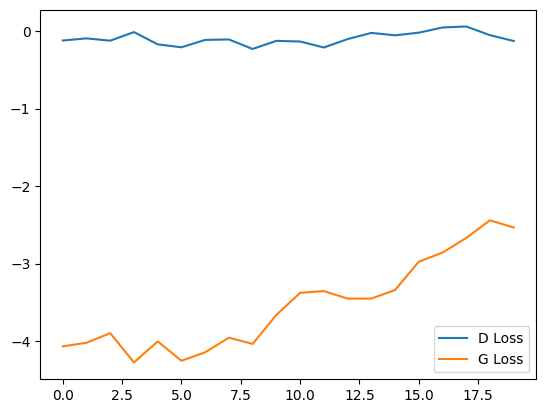

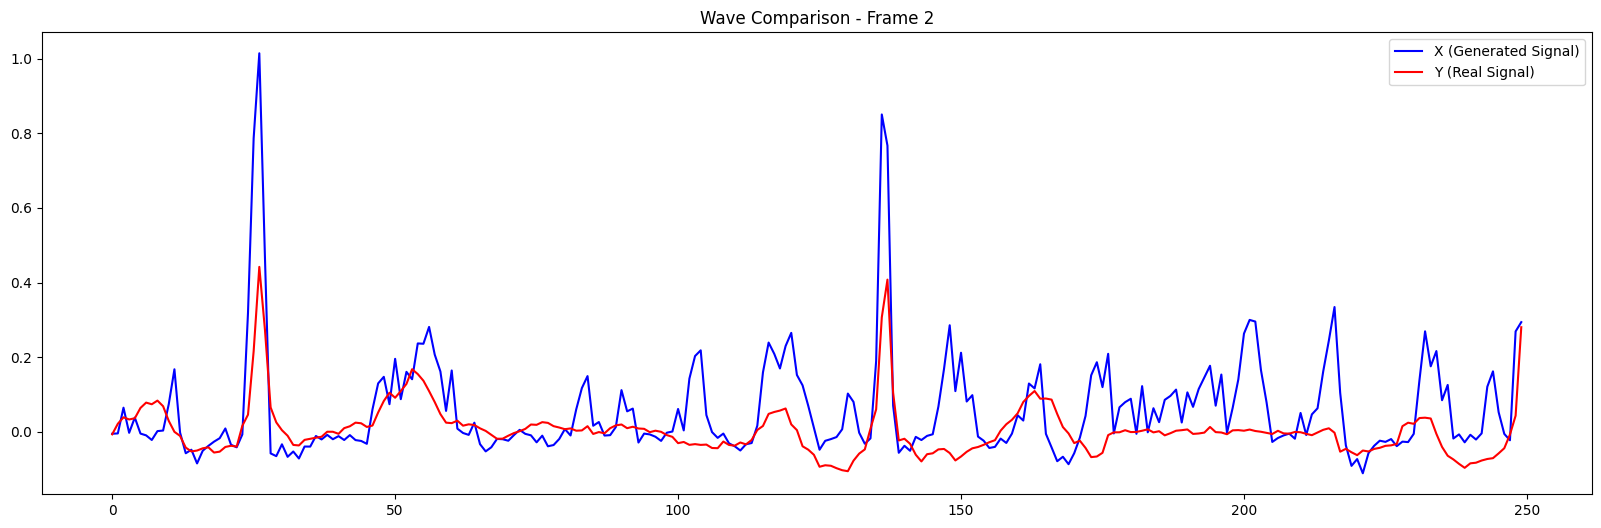

Frame 2:
Mean Squared Error (MSE): 0.0149
Fréchet Distance: 0.5725


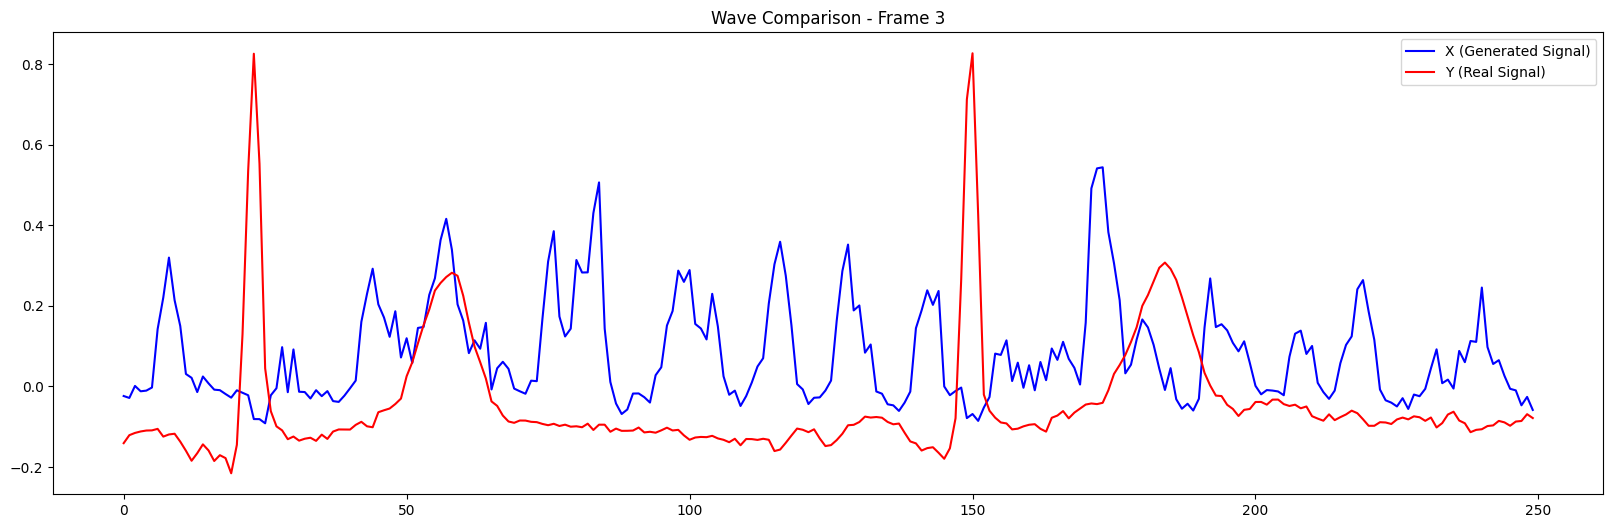

Frame 3:
Mean Squared Error (MSE): 0.0564
Fréchet Distance: 0.2829
Epoch 20/151, Critic Loss: -0.8057509660720825, Generator Loss: -3.3800854682922363
Epoch 21/151, Critic Loss: -0.16552218794822693, Generator Loss: -1.9804409742355347
Epoch 22/151, Critic Loss: 0.35657182335853577, Generator Loss: -1.8614554405212402
Epoch 23/151, Critic Loss: -0.776897132396698, Generator Loss: 0.07441330701112747
Epoch 24/151, Critic Loss: 0.4626152813434601, Generator Loss: -2.4787633419036865
Epoch 25/151, Critic Loss: -0.16989374160766602, Generator Loss: 0.3737286925315857
Epoch 26/151, Critic Loss: 0.10085110366344452, Generator Loss: 0.5251928567886353
Epoch 27/151, Critic Loss: 0.08972745388746262, Generator Loss: 1.241241455078125
Epoch 28/151, Critic Loss: -0.37196415662765503, Generator Loss: 0.41461360454559326
Epoch 29/151, Critic Loss: 0.08141094446182251, Generator Loss: 0.7205049395561218


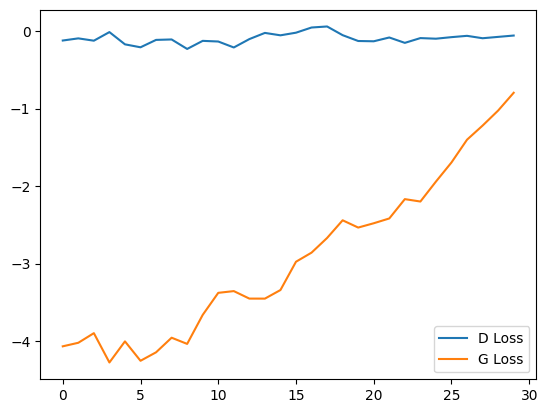

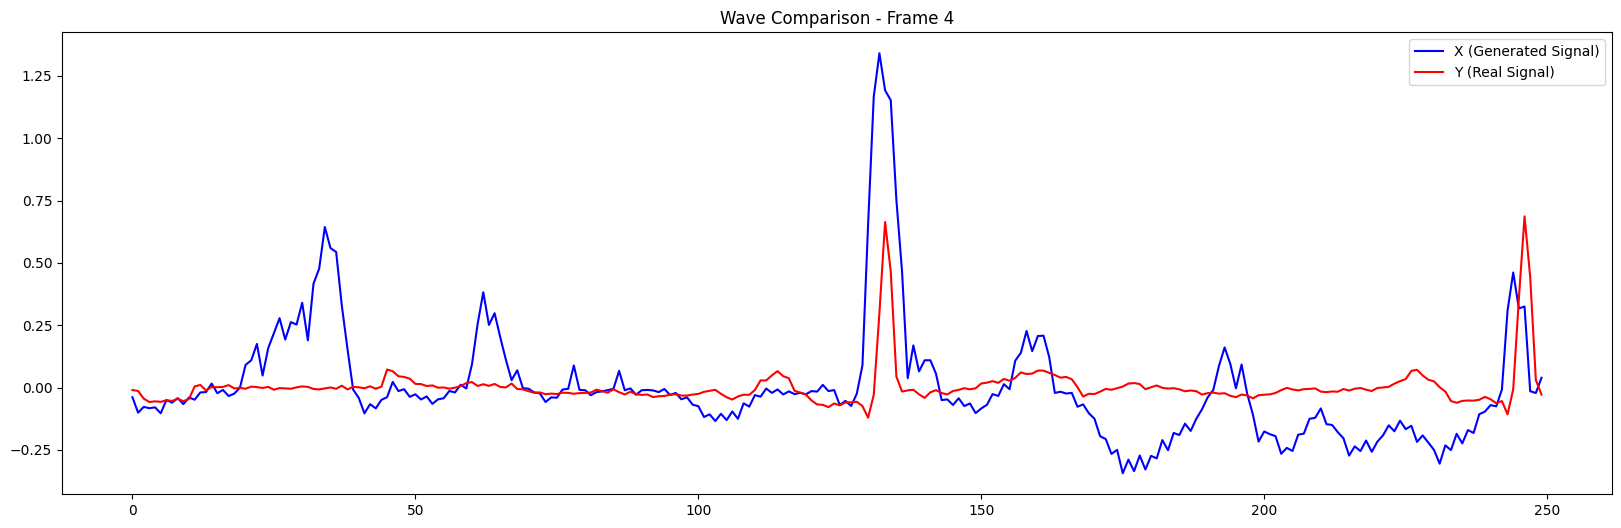

Frame 4:
Mean Squared Error (MSE): 0.0446
Fréchet Distance: 0.6539


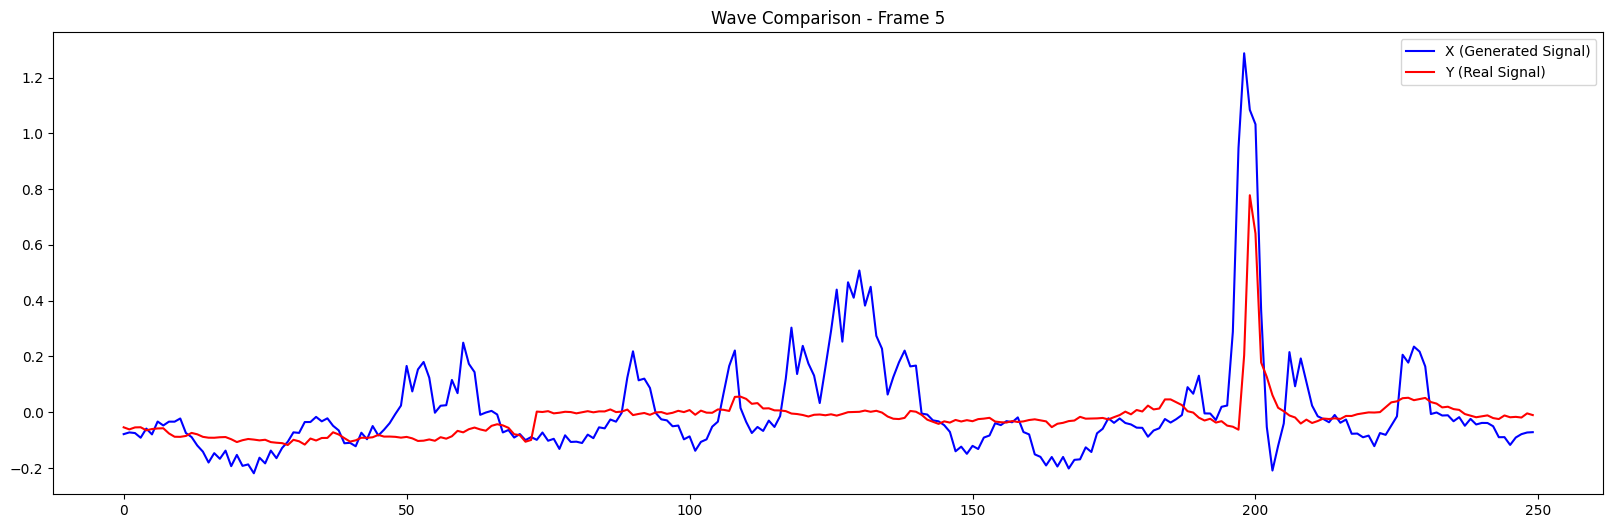

Frame 5:
Mean Squared Error (MSE): 0.0261
Fréchet Distance: 0.5090
Epoch 30/151, Critic Loss: 0.09702029824256897, Generator Loss: 1.2694804668426514
Epoch 31/151, Critic Loss: -0.6069301962852478, Generator Loss: 3.6835193634033203
Epoch 32/151, Critic Loss: -0.031482115387916565, Generator Loss: 2.4921789169311523
Epoch 33/151, Critic Loss: 0.07967422902584076, Generator Loss: 1.9736096858978271
Epoch 34/151, Critic Loss: -0.8242136836051941, Generator Loss: 4.806744575500488
Epoch 35/151, Critic Loss: 0.24011023342609406, Generator Loss: 0.7922888994216919
Epoch 36/151, Critic Loss: -0.28213730454444885, Generator Loss: 4.225706577301025
Epoch 37/151, Critic Loss: -0.31689491868019104, Generator Loss: 0.5390629768371582
Epoch 38/151, Critic Loss: -0.17504073679447174, Generator Loss: 1.8413065671920776
Epoch 39/151, Critic Loss: 0.2529393434524536, Generator Loss: 2.0645246505737305


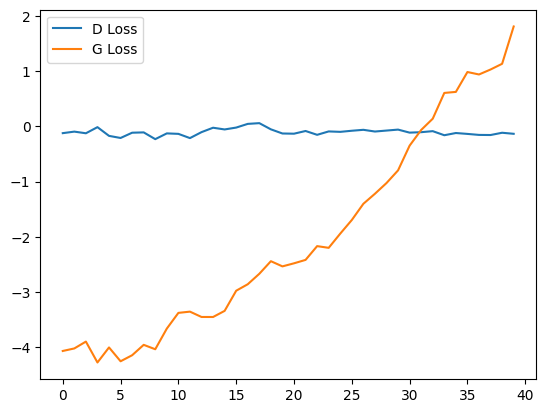

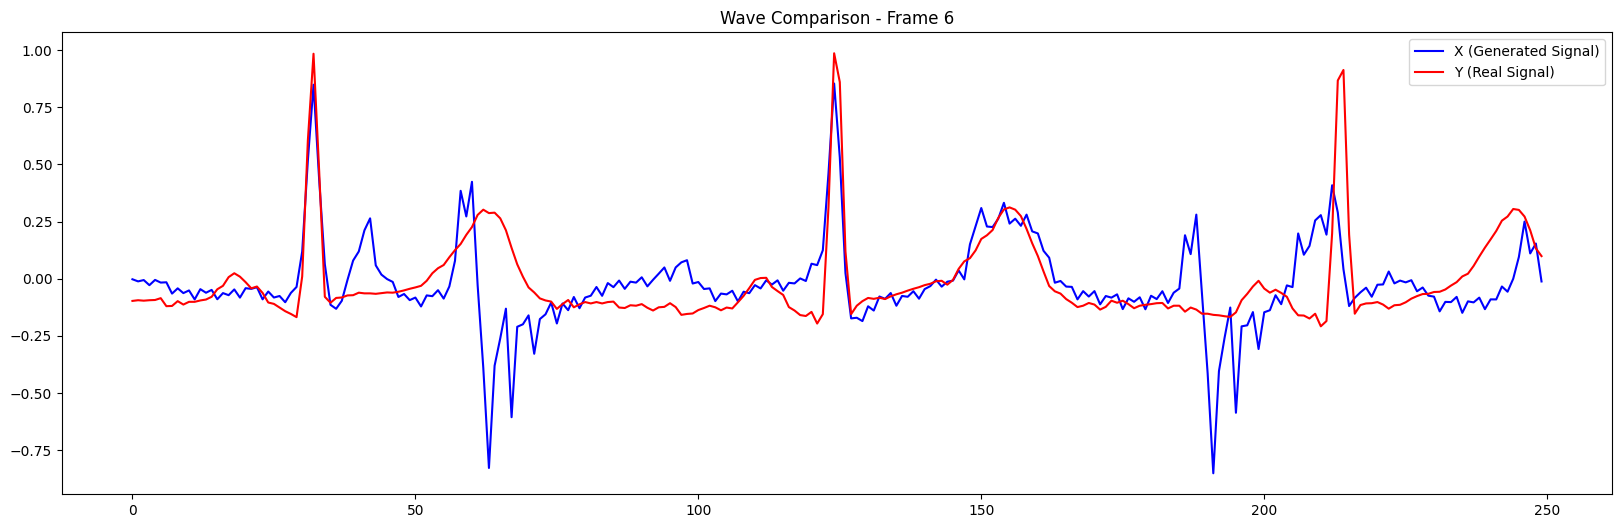

Frame 6:
Mean Squared Error (MSE): 0.0368
Fréchet Distance: 0.6428


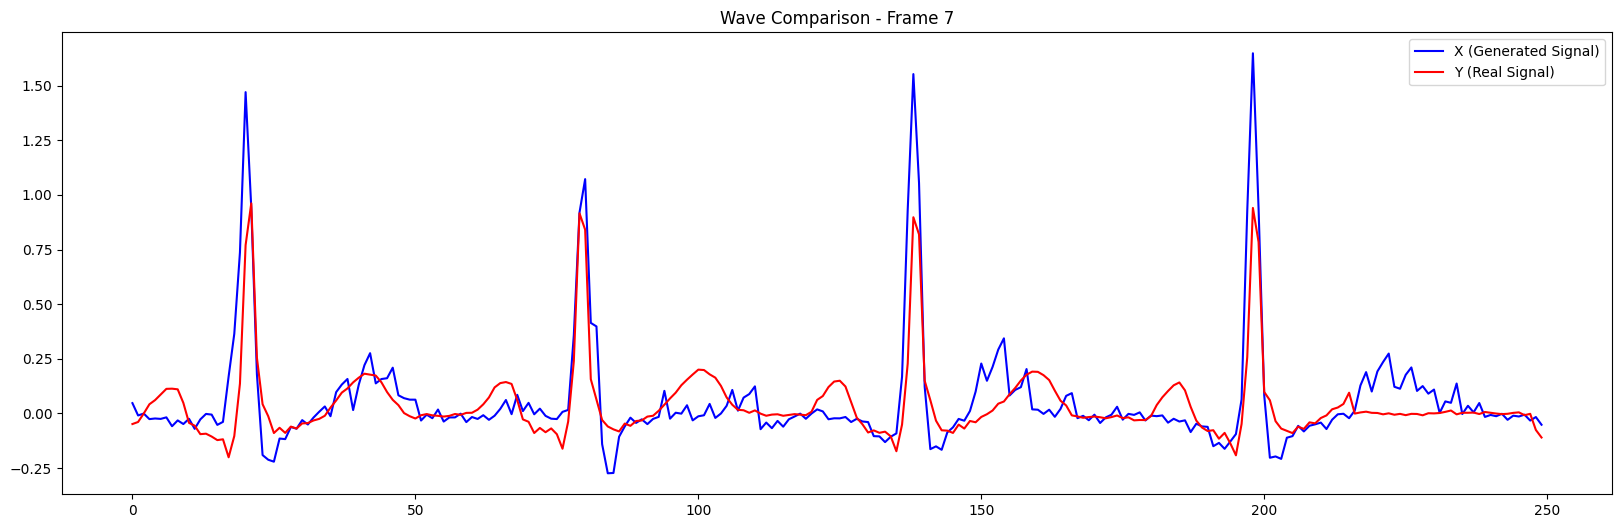

Frame 7:
Mean Squared Error (MSE): 0.0228
Fréchet Distance: 0.6866
Epoch 40/151, Critic Loss: -0.3052799105644226, Generator Loss: 7.893088340759277
Epoch 41/151, Critic Loss: 0.20425856113433838, Generator Loss: 5.4381537437438965
Epoch 42/151, Critic Loss: 0.277465283870697, Generator Loss: 4.389849662780762
Epoch 43/151, Critic Loss: -0.04830939322710037, Generator Loss: 3.444253921508789
Epoch 44/151, Critic Loss: -0.32014453411102295, Generator Loss: 3.9571943283081055
Epoch 45/151, Critic Loss: 0.1894625425338745, Generator Loss: 4.825620174407959
Epoch 46/151, Critic Loss: 0.10874836891889572, Generator Loss: 3.654280185699463
Epoch 47/151, Critic Loss: -0.16891862452030182, Generator Loss: 2.220306158065796
Epoch 48/151, Critic Loss: 0.22394651174545288, Generator Loss: 1.46583890914917
Epoch 49/151, Critic Loss: 0.1415719985961914, Generator Loss: 0.4615275263786316


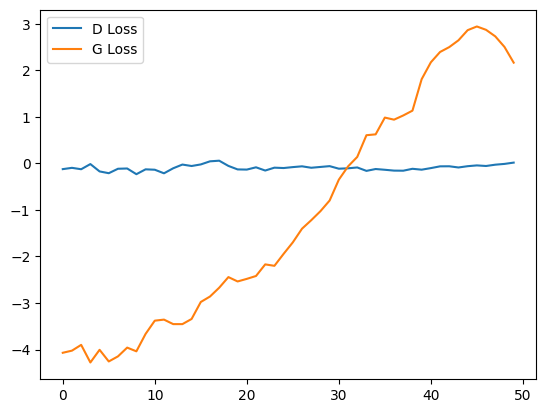

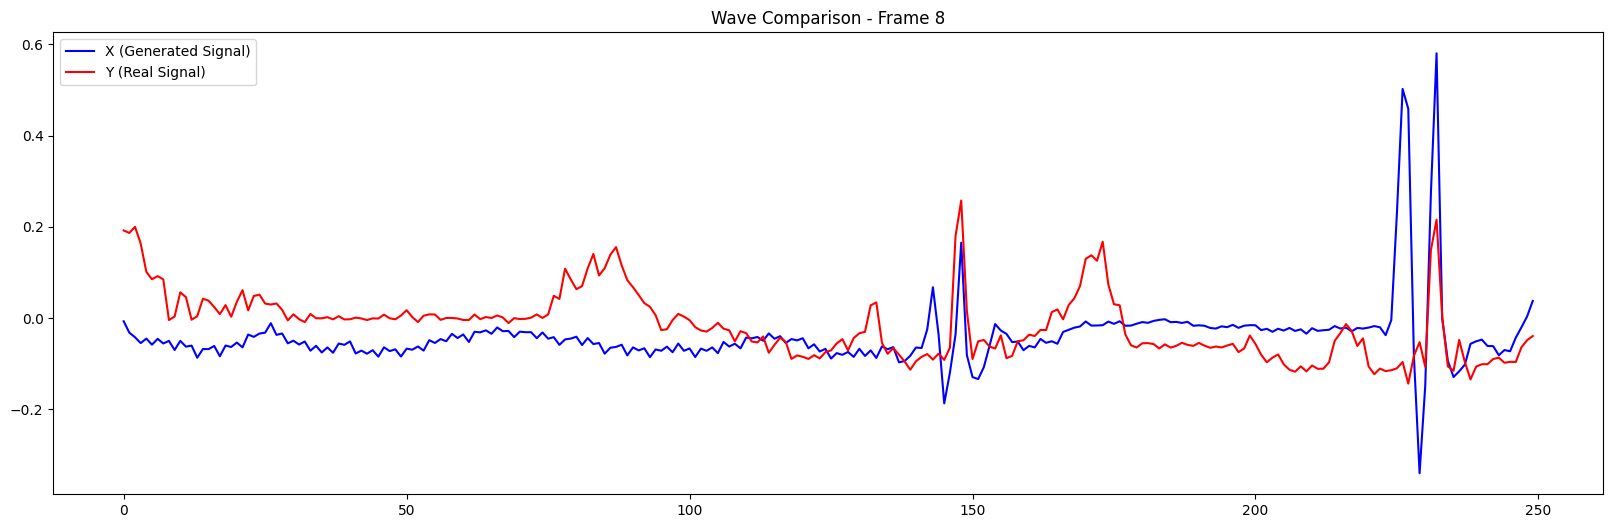

Frame 8:
Mean Squared Error (MSE): 0.0105
Fréchet Distance: 0.3232


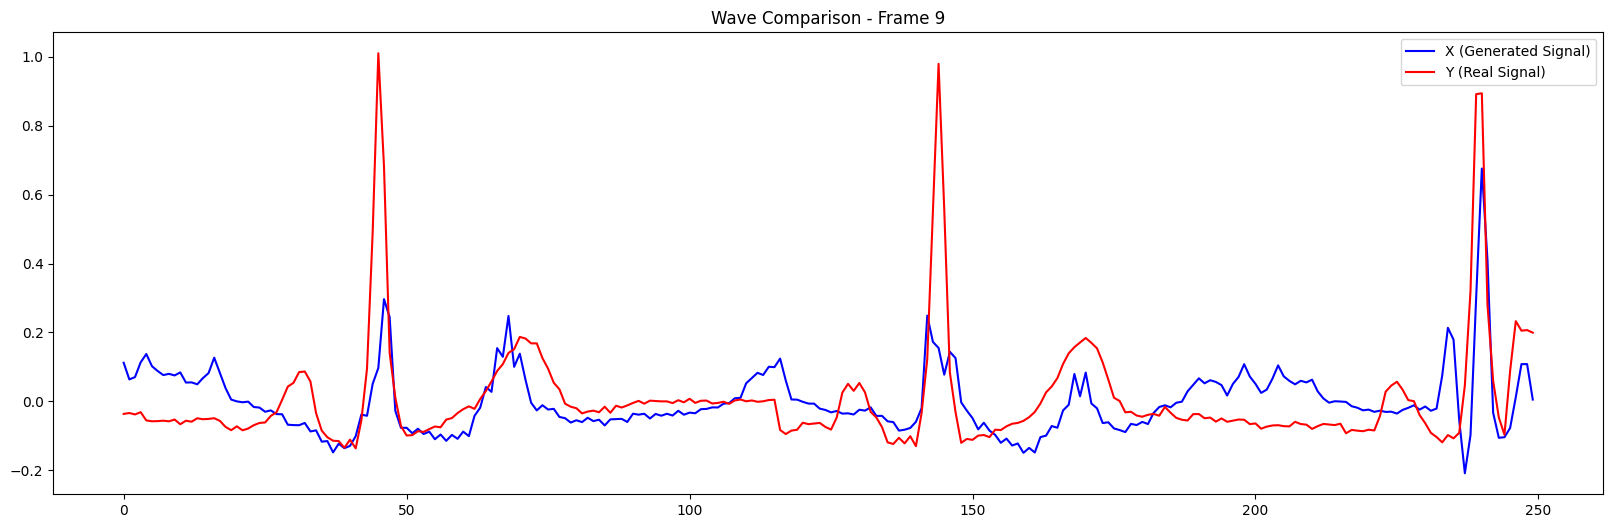

Frame 9:
Mean Squared Error (MSE): 0.0199
Fréchet Distance: 0.3344
Epoch 50/151, Critic Loss: 0.2679467499256134, Generator Loss: -0.8758748769760132
Epoch 51/151, Critic Loss: -0.1332651525735855, Generator Loss: 2.350856065750122
Epoch 52/151, Critic Loss: -0.1588568389415741, Generator Loss: 8.638629913330078
Epoch 53/151, Critic Loss: -0.15499655902385712, Generator Loss: 1.770491361618042
Epoch 54/151, Critic Loss: -0.4192362427711487, Generator Loss: 5.366964340209961
Epoch 55/151, Critic Loss: -0.2632809579372406, Generator Loss: 2.835117816925049
Epoch 56/151, Critic Loss: -0.03379299119114876, Generator Loss: 6.921643257141113
Epoch 57/151, Critic Loss: 0.1227145791053772, Generator Loss: -0.08510443568229675
Epoch 58/151, Critic Loss: -0.49287211894989014, Generator Loss: 1.6031420230865479
Epoch 59/151, Critic Loss: 0.10215134918689728, Generator Loss: 5.720677375793457


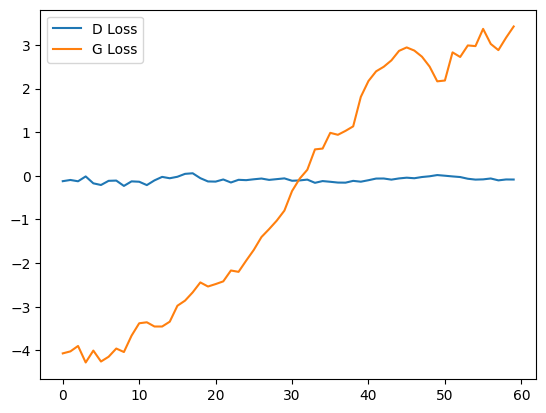

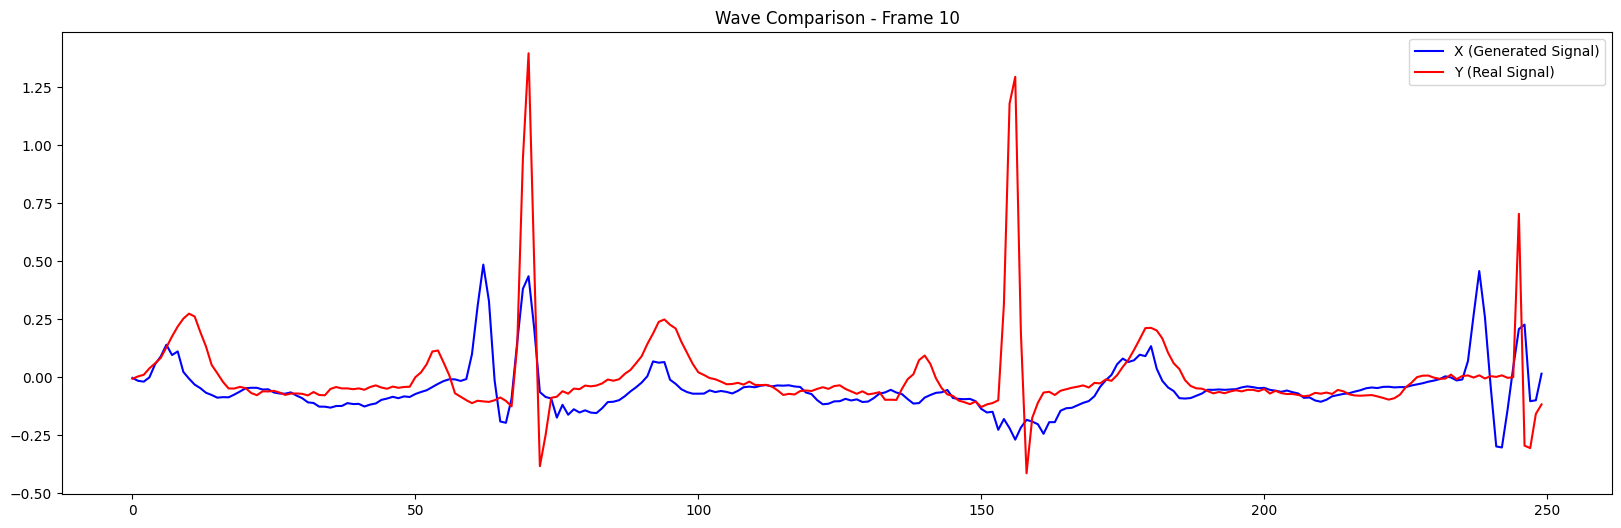

Frame 10:
Mean Squared Error (MSE): 0.0388
Fréchet Distance: 0.9109


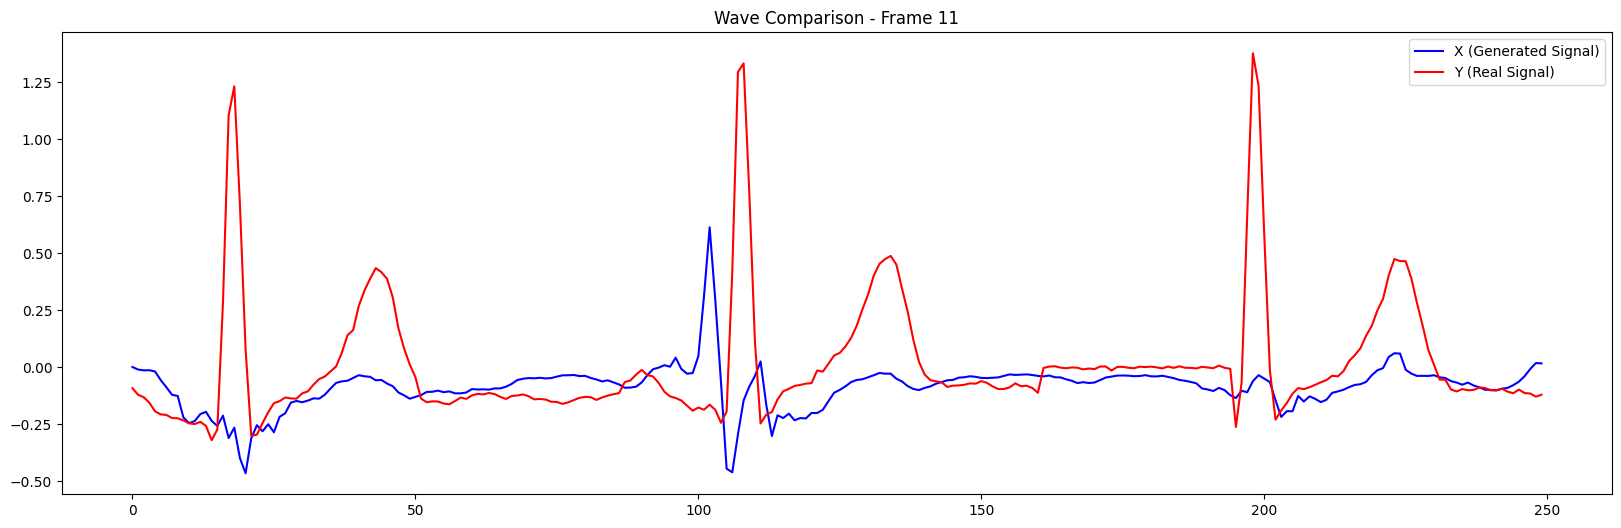

Frame 11:
Mean Squared Error (MSE): 0.0963
Fréchet Distance: 0.7636
Epoch 60/151, Critic Loss: -0.098185233771801, Generator Loss: 5.7418928146362305
Epoch 61/151, Critic Loss: -0.05086689069867134, Generator Loss: 3.8768458366394043
Epoch 62/151, Critic Loss: -0.46554940938949585, Generator Loss: 7.543981075286865
Epoch 63/151, Critic Loss: -0.625117301940918, Generator Loss: 3.5829415321350098
Epoch 64/151, Critic Loss: -0.47110968828201294, Generator Loss: 7.934499740600586
Epoch 65/151, Critic Loss: 0.7359142303466797, Generator Loss: 4.905322074890137
Epoch 66/151, Critic Loss: 0.15360158681869507, Generator Loss: 10.655717849731445
Epoch 67/151, Critic Loss: -0.07200916111469269, Generator Loss: 7.164860725402832
Epoch 68/151, Critic Loss: -0.3368816375732422, Generator Loss: 1.604173183441162
Epoch 69/151, Critic Loss: -0.31600913405418396, Generator Loss: 9.88805103302002


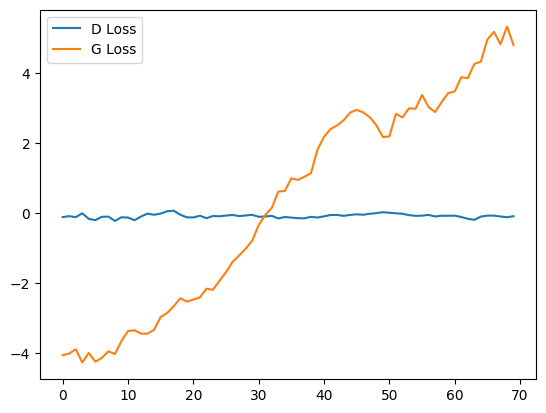

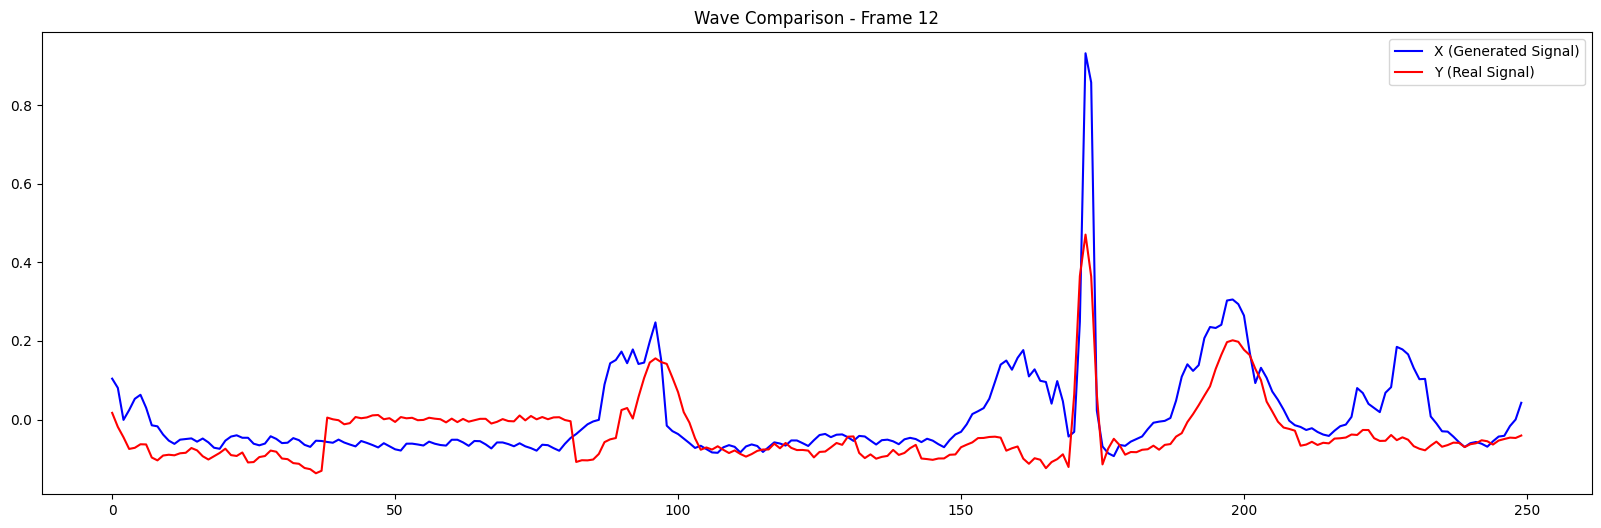

Frame 12:
Mean Squared Error (MSE): 0.0091
Fréchet Distance: 0.4613


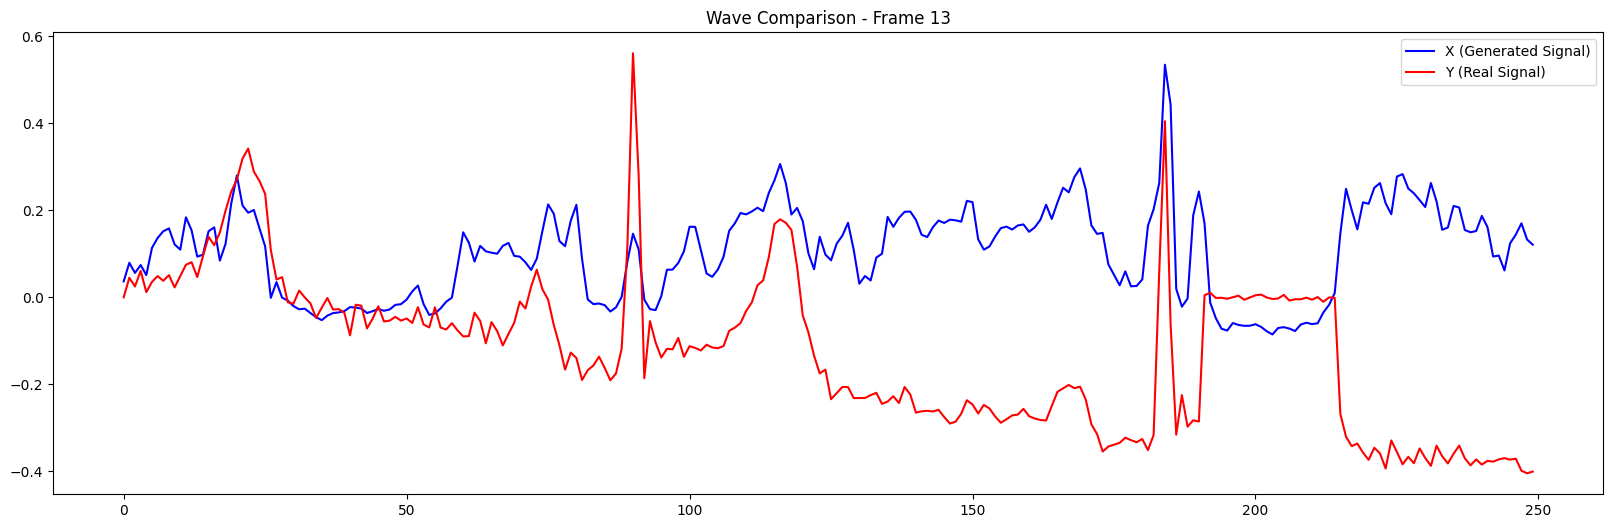

Frame 13:
Mean Squared Error (MSE): 0.0994
Fréchet Distance: 0.3194
Epoch 70/151, Critic Loss: 0.16438670456409454, Generator Loss: 0.011157535016536713
Epoch 71/151, Critic Loss: -0.36914971470832825, Generator Loss: 11.272806167602539
Epoch 72/151, Critic Loss: 0.2598762512207031, Generator Loss: 7.773491859436035
Epoch 73/151, Critic Loss: -0.019371474161744118, Generator Loss: 5.429296493530273
Epoch 74/151, Critic Loss: 0.044654153287410736, Generator Loss: 4.257762908935547
Epoch 75/151, Critic Loss: -0.35619232058525085, Generator Loss: 12.036853790283203
Epoch 76/151, Critic Loss: 0.6459051966667175, Generator Loss: 6.121013641357422
Epoch 77/151, Critic Loss: 0.03967579826712608, Generator Loss: 8.683032989501953
Epoch 78/151, Critic Loss: -1.0896122455596924, Generator Loss: 8.761967658996582
Epoch 79/151, Critic Loss: -0.5165743231773376, Generator Loss: 10.40643310546875


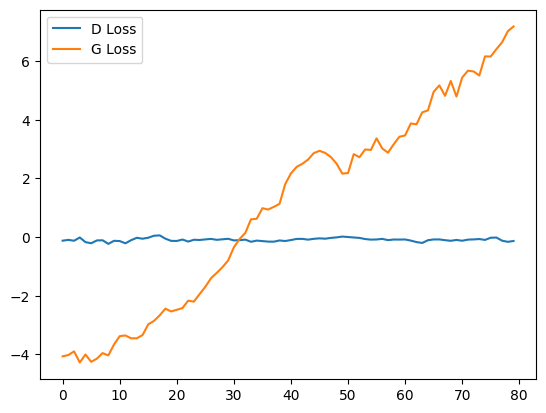

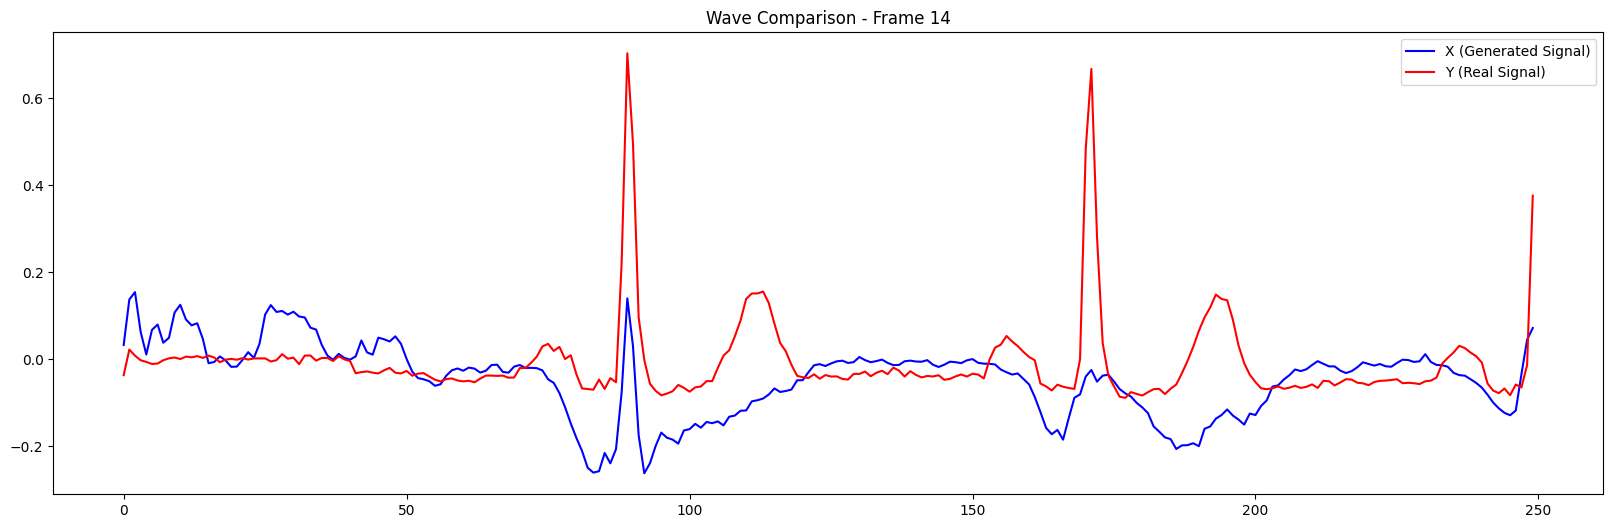

Frame 14:
Mean Squared Error (MSE): 0.0154
Fréchet Distance: 0.5491


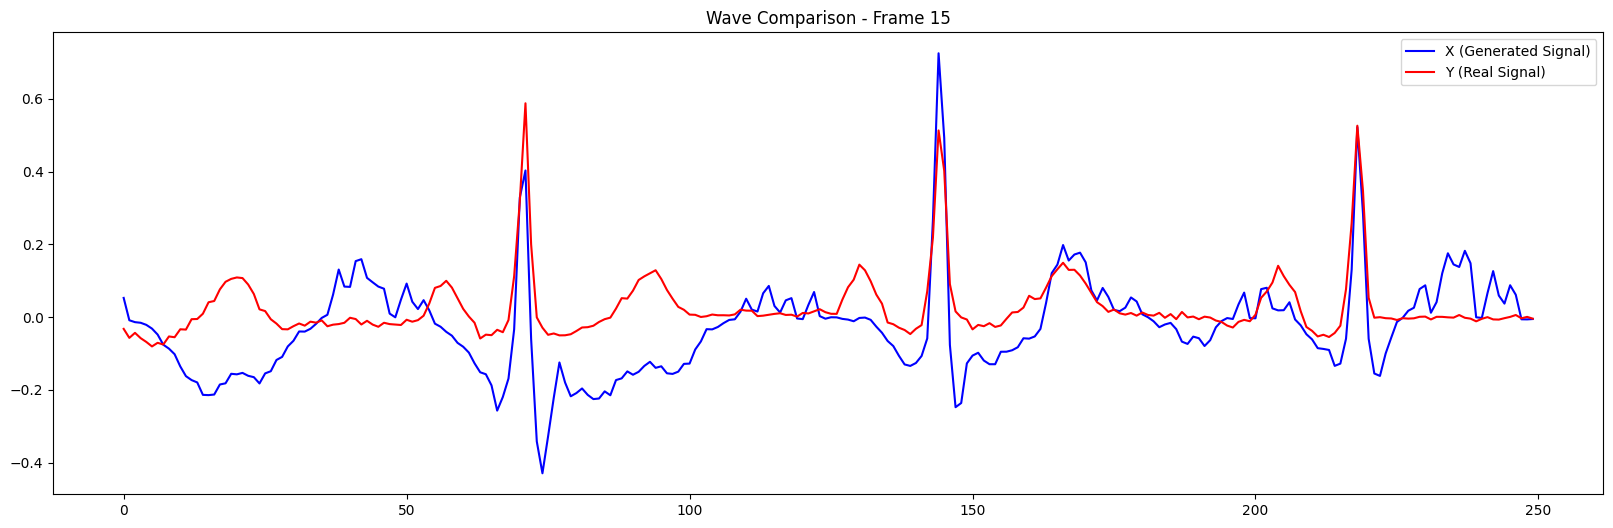

Frame 15:
Mean Squared Error (MSE): 0.0150
Fréchet Distance: 0.3485
Epoch 80/151, Critic Loss: 0.1318199634552002, Generator Loss: 8.62901496887207
Epoch 81/151, Critic Loss: 0.41302943229675293, Generator Loss: 8.720134735107422
Epoch 82/151, Critic Loss: 0.06831786036491394, Generator Loss: 9.927842140197754
Epoch 83/151, Critic Loss: -0.32813817262649536, Generator Loss: 1.8483408689498901
Epoch 84/151, Critic Loss: -0.33409208059310913, Generator Loss: 13.196432113647461
Epoch 85/151, Critic Loss: 0.4366404414176941, Generator Loss: 5.078761100769043
Epoch 86/151, Critic Loss: 0.1491623818874359, Generator Loss: 0.10629825294017792
Epoch 87/151, Critic Loss: -0.8009857535362244, Generator Loss: 13.886015892028809
Epoch 88/151, Critic Loss: 0.5436774492263794, Generator Loss: 10.635246276855469
Epoch 89/151, Critic Loss: -0.27712497115135193, Generator Loss: 8.64877700805664


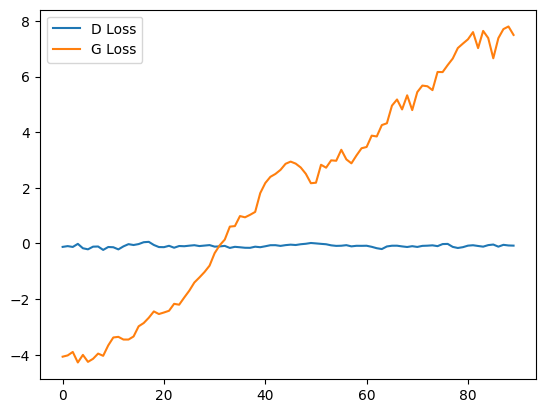

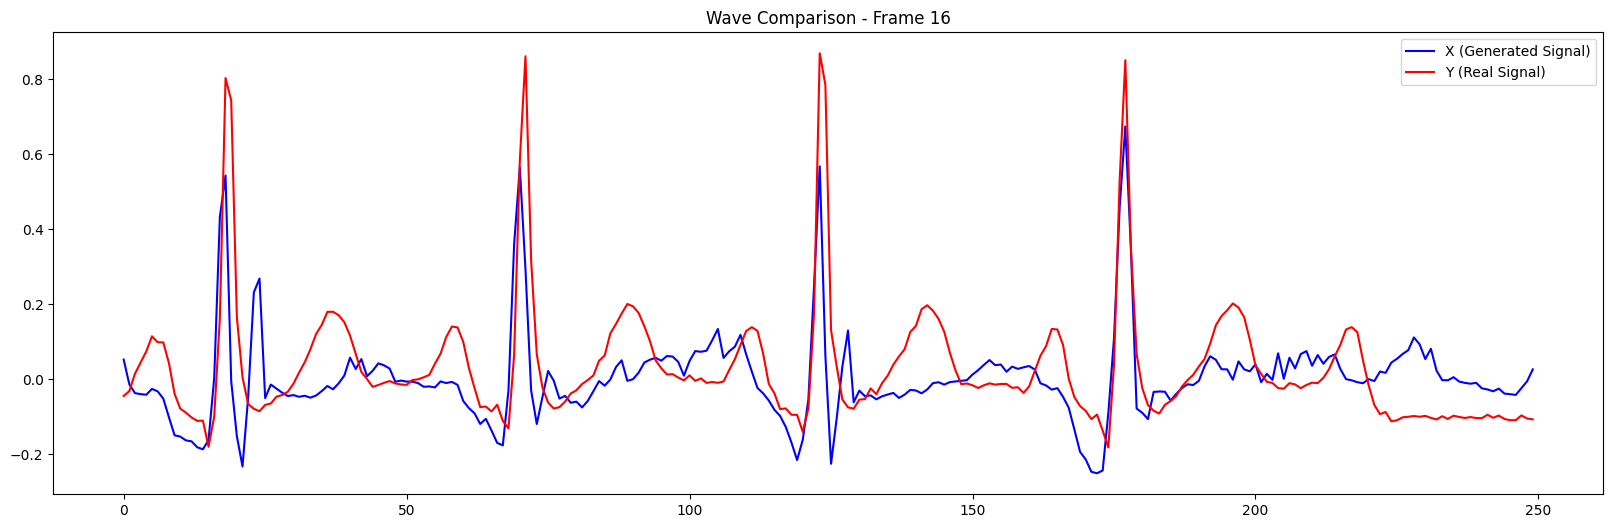

Frame 16:
Mean Squared Error (MSE): 0.0185
Fréchet Distance: 0.1952


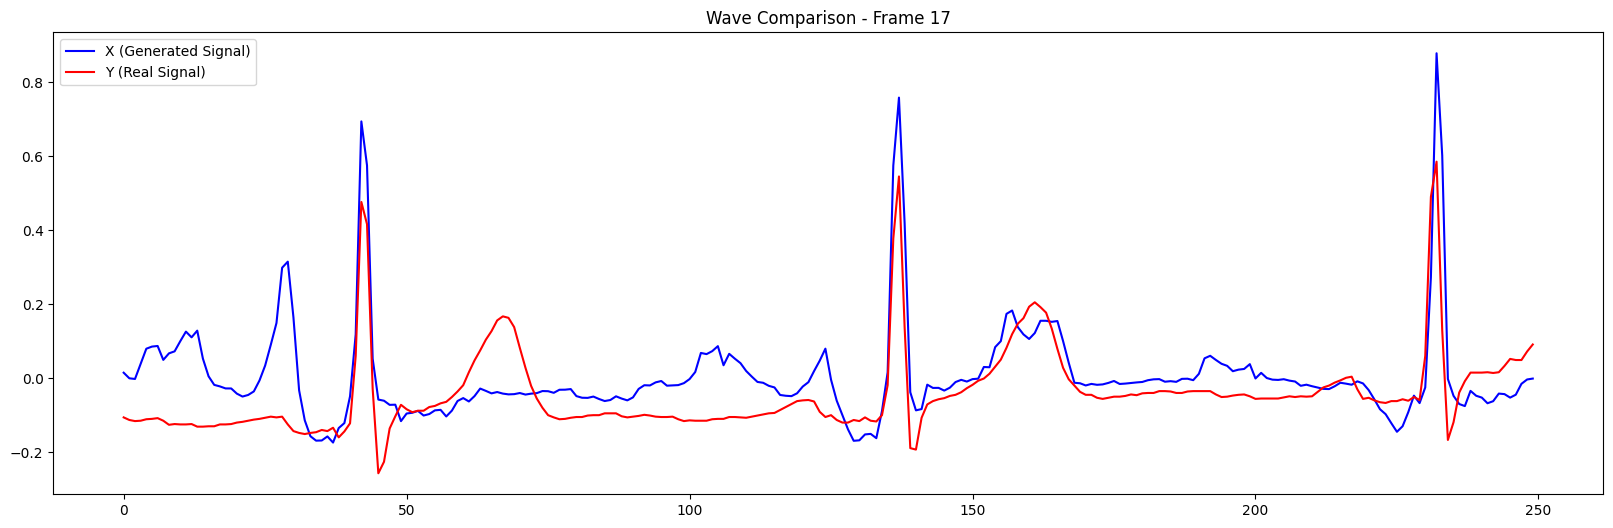

Frame 17:
Mean Squared Error (MSE): 0.0122
Fréchet Distance: 0.2928
Epoch 90/151, Critic Loss: -0.13081055879592896, Generator Loss: 4.754875659942627
Epoch 91/151, Critic Loss: -0.3762112557888031, Generator Loss: 8.913481712341309
Epoch 92/151, Critic Loss: -0.8286097049713135, Generator Loss: 9.331966400146484
Epoch 93/151, Critic Loss: -0.60783851146698, Generator Loss: 10.297086715698242
Epoch 94/151, Critic Loss: 0.6904177665710449, Generator Loss: 8.017783164978027
Epoch 95/151, Critic Loss: -0.11918051540851593, Generator Loss: 6.934039115905762
Epoch 96/151, Critic Loss: -0.6279703974723816, Generator Loss: 14.108902931213379
Epoch 97/151, Critic Loss: 0.37288105487823486, Generator Loss: 7.891427516937256
Epoch 98/151, Critic Loss: 0.0785110592842102, Generator Loss: 8.649496078491211
Epoch 99/151, Critic Loss: -1.0791821479797363, Generator Loss: 10.092609405517578


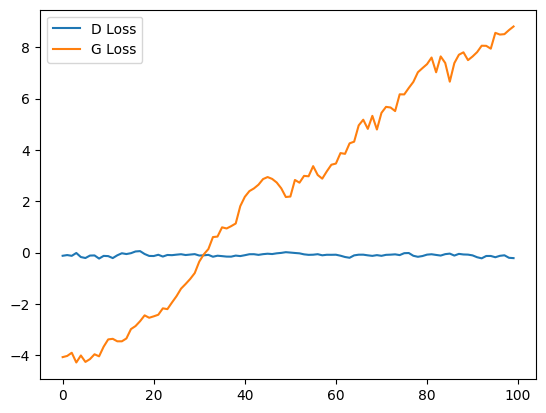

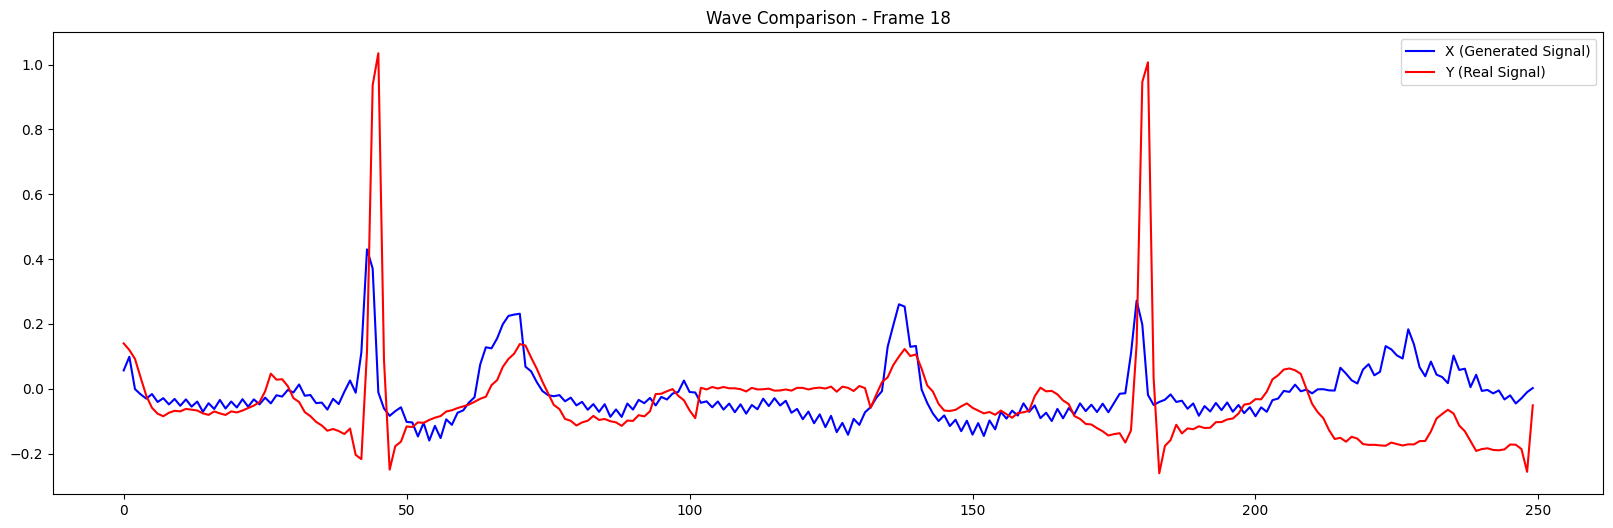

Frame 18:
Mean Squared Error (MSE): 0.0236
Fréchet Distance: 0.6048


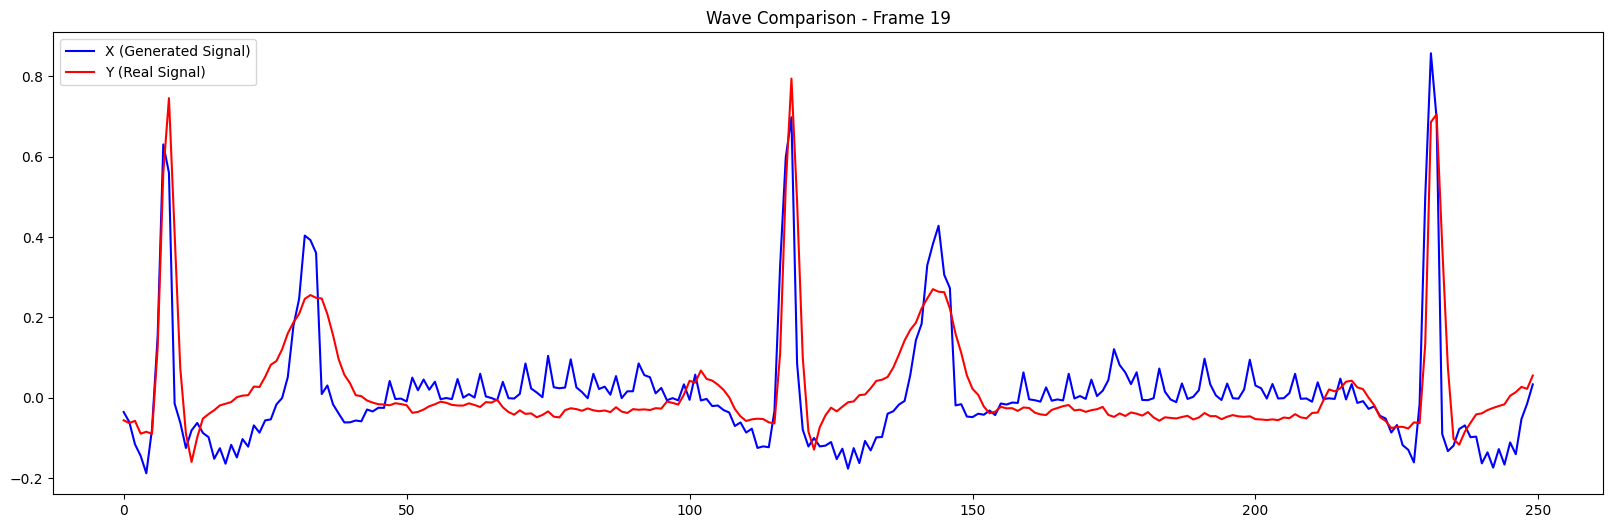

Frame 19:
Mean Squared Error (MSE): 0.0097
Fréchet Distance: 0.0631
Epoch 100/151, Critic Loss: -0.3284538984298706, Generator Loss: 10.064169883728027
Epoch 101/151, Critic Loss: -0.25860127806663513, Generator Loss: 10.395598411560059
Epoch 102/151, Critic Loss: -0.48098742961883545, Generator Loss: 11.467551231384277
Epoch 103/151, Critic Loss: 0.2421053647994995, Generator Loss: 15.383678436279297
Epoch 104/151, Critic Loss: 0.5050274133682251, Generator Loss: 12.113275527954102
Epoch 105/151, Critic Loss: 0.08614072948694229, Generator Loss: 5.821639060974121
Epoch 106/151, Critic Loss: 0.7686364650726318, Generator Loss: 15.352437019348145
Epoch 107/151, Critic Loss: -0.5056889057159424, Generator Loss: 14.119366645812988
Epoch 108/151, Critic Loss: -0.12753748893737793, Generator Loss: 10.378253936767578
Epoch 109/151, Critic Loss: -0.7740939855575562, Generator Loss: 12.68041706085205


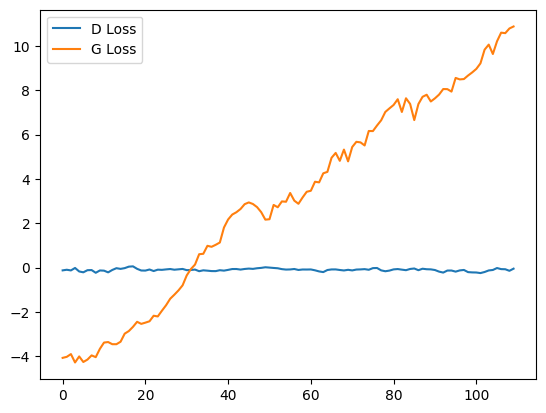

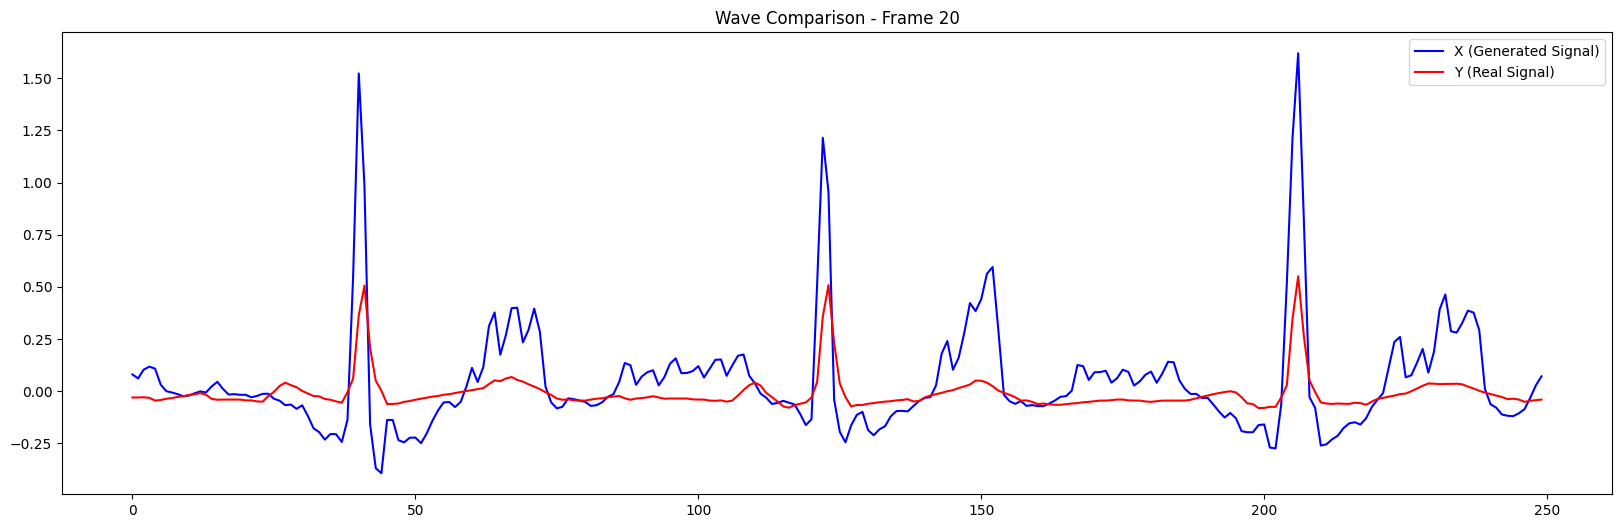

Frame 20:
Mean Squared Error (MSE): 0.0452
Fréchet Distance: 1.0684


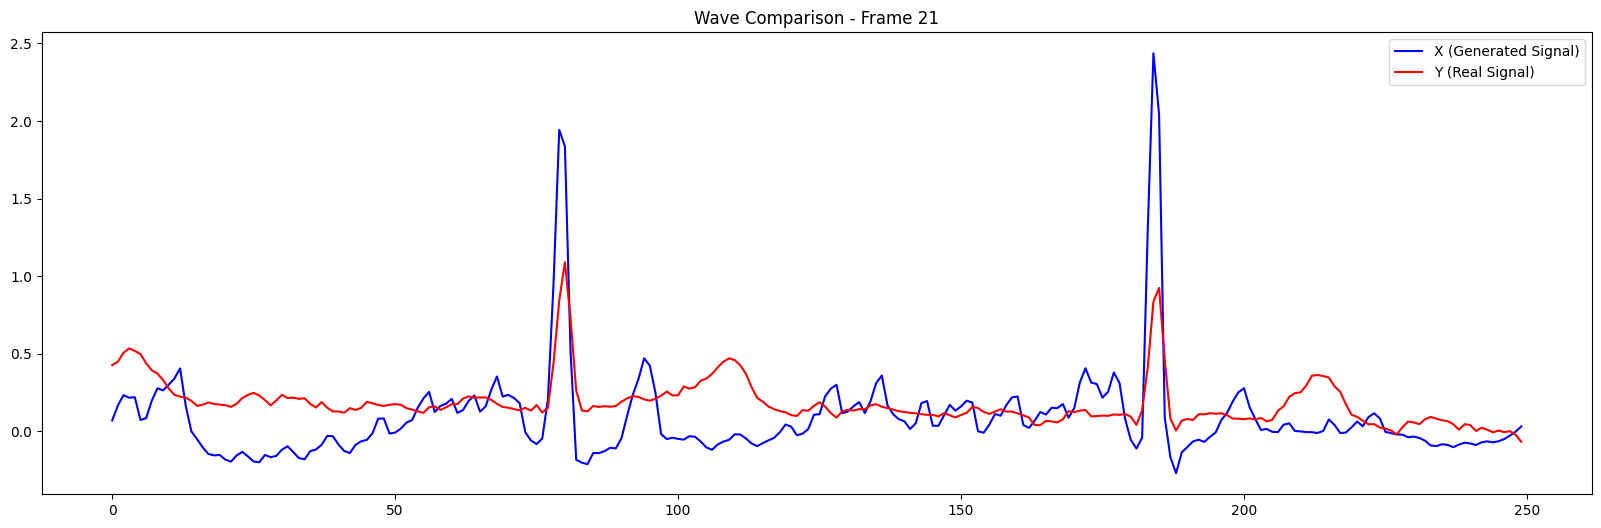

Frame 21:
Mean Squared Error (MSE): 0.0710
Fréchet Distance: 1.3466
Epoch 110/151, Critic Loss: 0.8261999487876892, Generator Loss: 11.689220428466797
Epoch 111/151, Critic Loss: -0.12114224582910538, Generator Loss: 6.86662483215332
Epoch 112/151, Critic Loss: 0.42277079820632935, Generator Loss: 7.28579044342041
Epoch 113/151, Critic Loss: 0.039098337292671204, Generator Loss: 6.836573600769043
Epoch 114/151, Critic Loss: -0.1114673763513565, Generator Loss: 8.762245178222656
Epoch 115/151, Critic Loss: -0.8007760047912598, Generator Loss: 8.106985092163086
Epoch 116/151, Critic Loss: 0.18041293323040009, Generator Loss: 9.057846069335938
Epoch 117/151, Critic Loss: -0.19035562872886658, Generator Loss: 14.358647346496582
Epoch 118/151, Critic Loss: 0.22406694293022156, Generator Loss: 8.243583679199219
Epoch 119/151, Critic Loss: -0.4761447310447693, Generator Loss: 14.373756408691406


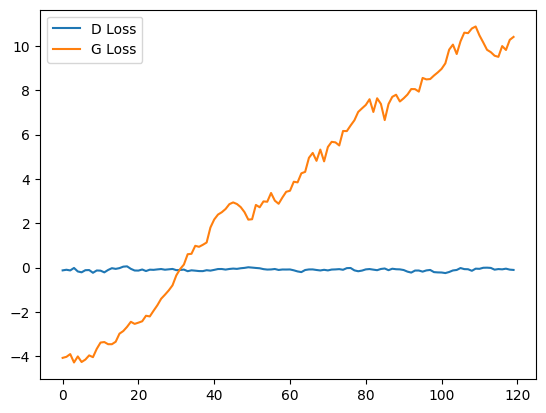

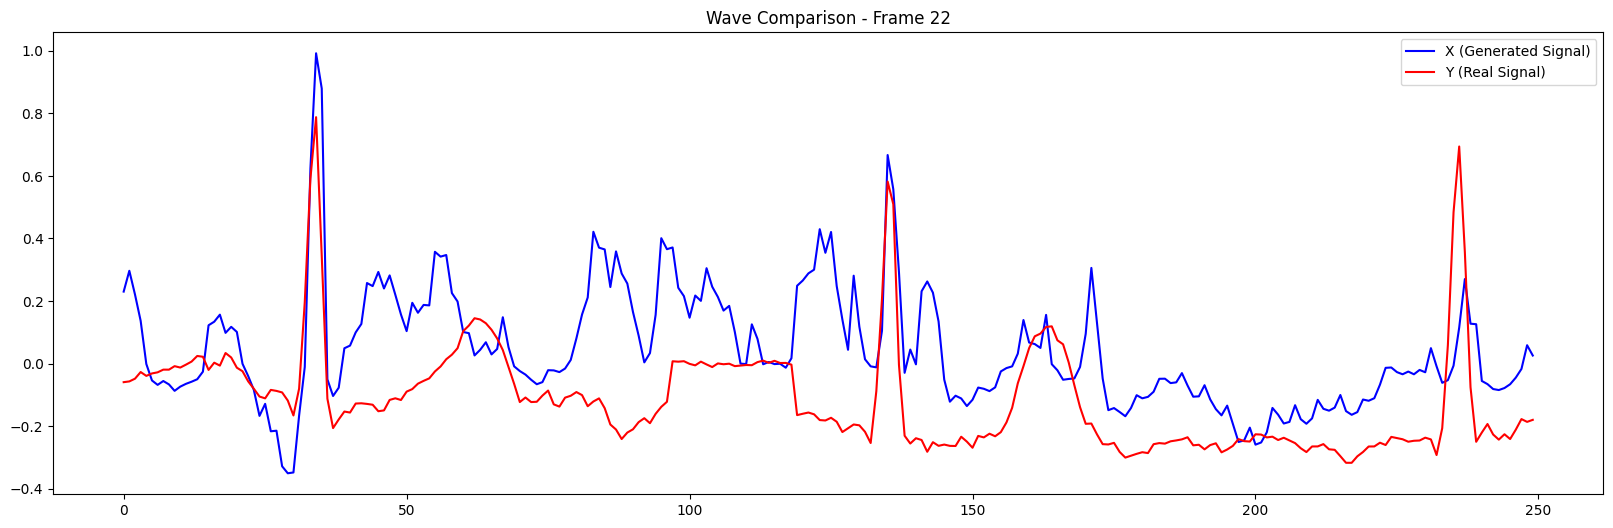

Frame 22:
Mean Squared Error (MSE): 0.0559
Fréchet Distance: 0.2044


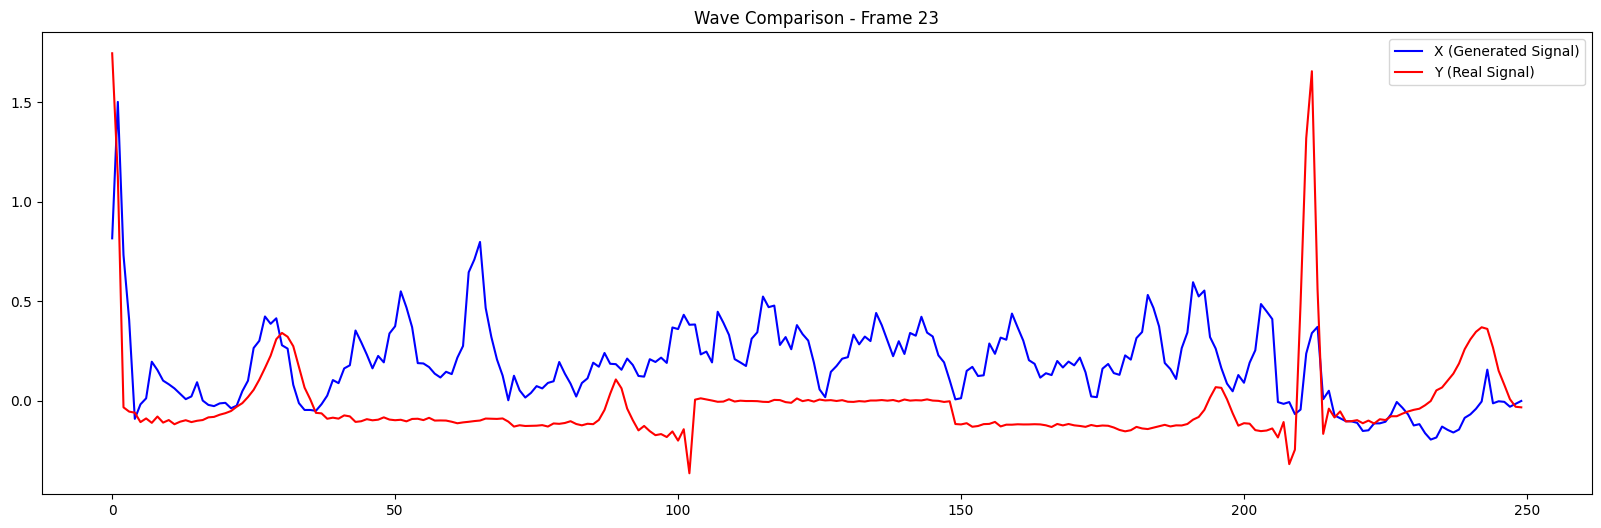

Frame 23:
Mean Squared Error (MSE): 0.1134
Fréchet Distance: 0.3090
Epoch 120/151, Critic Loss: -0.22449800372123718, Generator Loss: 11.607416152954102
Epoch 121/151, Critic Loss: 0.18900178372859955, Generator Loss: 13.235275268554688
Epoch 122/151, Critic Loss: -0.04667682573199272, Generator Loss: 13.696352005004883
Epoch 123/151, Critic Loss: -0.5601931810379028, Generator Loss: 12.953704833984375
Epoch 124/151, Critic Loss: 0.29629573225975037, Generator Loss: 11.286066055297852
Epoch 125/151, Critic Loss: 0.30097004771232605, Generator Loss: 9.681930541992188
Epoch 126/151, Critic Loss: -0.5980912446975708, Generator Loss: 15.625869750976562
Epoch 127/151, Critic Loss: 0.312757670879364, Generator Loss: 12.600481033325195
Epoch 128/151, Critic Loss: 0.3293755352497101, Generator Loss: 8.447038650512695
Epoch 129/151, Critic Loss: -0.1807476282119751, Generator Loss: 14.140459060668945


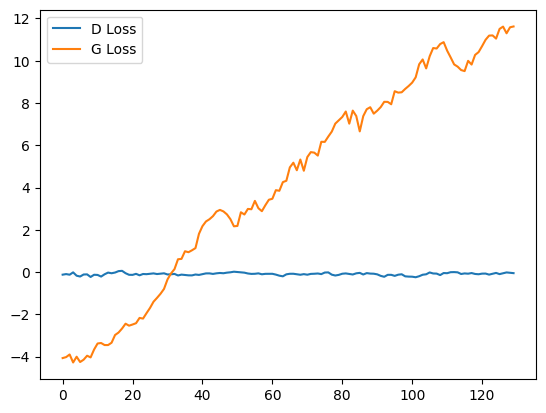

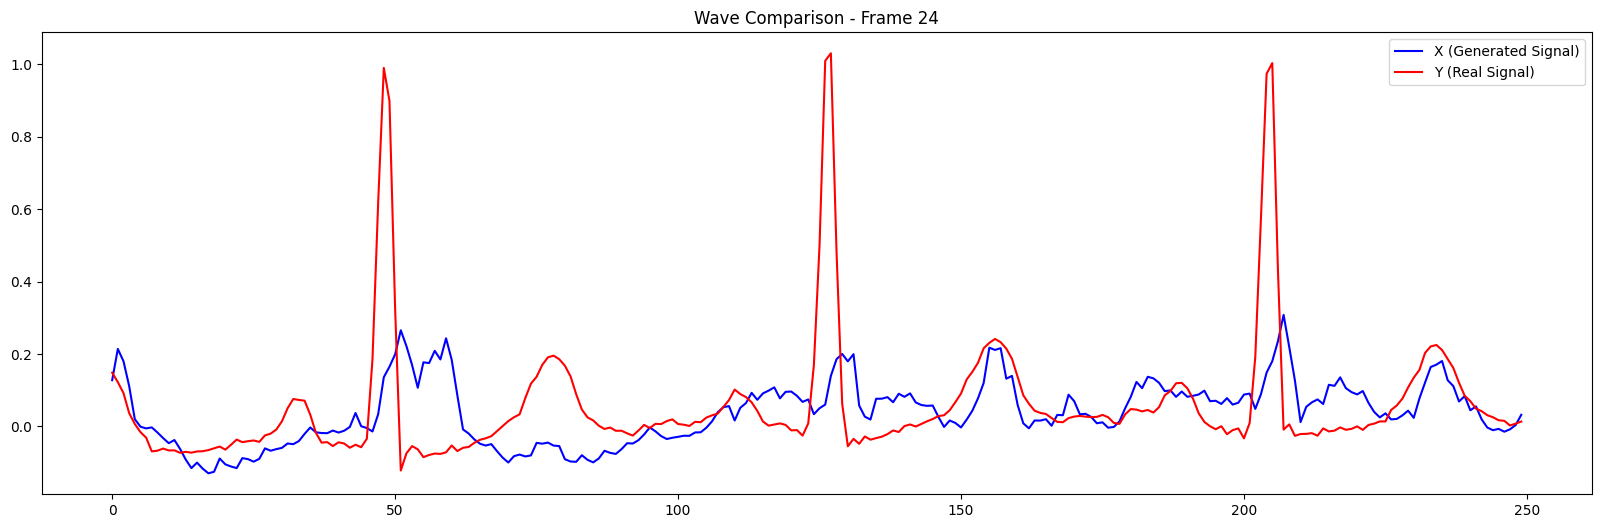

Frame 24:
Mean Squared Error (MSE): 0.0308
Fréchet Distance: 0.7222


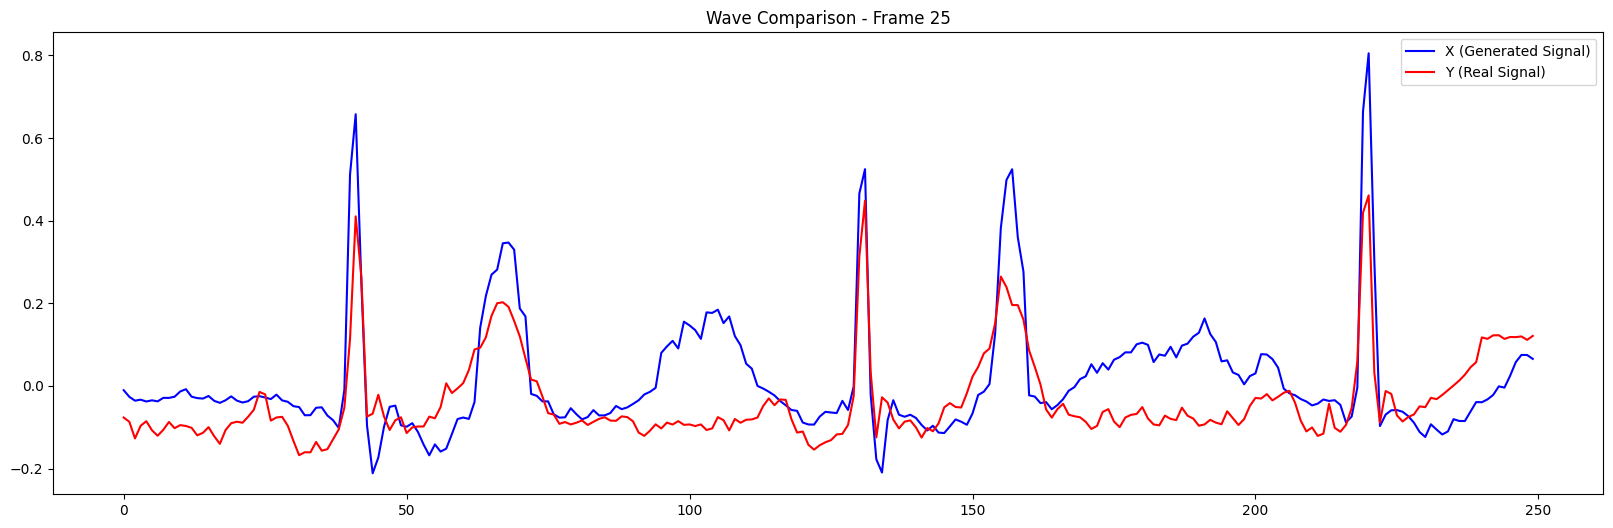

Frame 25:
Mean Squared Error (MSE): 0.0131
Fréchet Distance: 0.3438
Epoch 130/151, Critic Loss: -0.20915532112121582, Generator Loss: 11.961217880249023
Epoch 131/151, Critic Loss: -0.23344272375106812, Generator Loss: 13.531240463256836
Epoch 132/151, Critic Loss: -0.11504969745874405, Generator Loss: 9.535127639770508
Epoch 133/151, Critic Loss: -0.03330928832292557, Generator Loss: 10.793426513671875
Epoch 134/151, Critic Loss: -0.001505676656961441, Generator Loss: 11.558295249938965
Epoch 135/151, Critic Loss: 0.03525235131382942, Generator Loss: 7.751987457275391
Epoch 136/151, Critic Loss: -0.13121114671230316, Generator Loss: 11.357454299926758
Epoch 137/151, Critic Loss: 0.0165100060403347, Generator Loss: 11.211950302124023
Epoch 138/151, Critic Loss: 0.04790139198303223, Generator Loss: 9.75813102722168
Epoch 139/151, Critic Loss: 0.04088347405195236, Generator Loss: 14.616510391235352


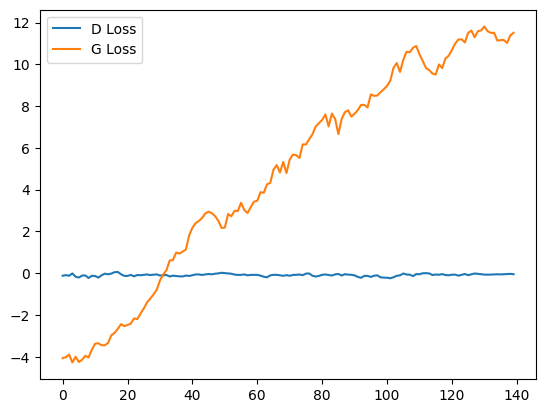

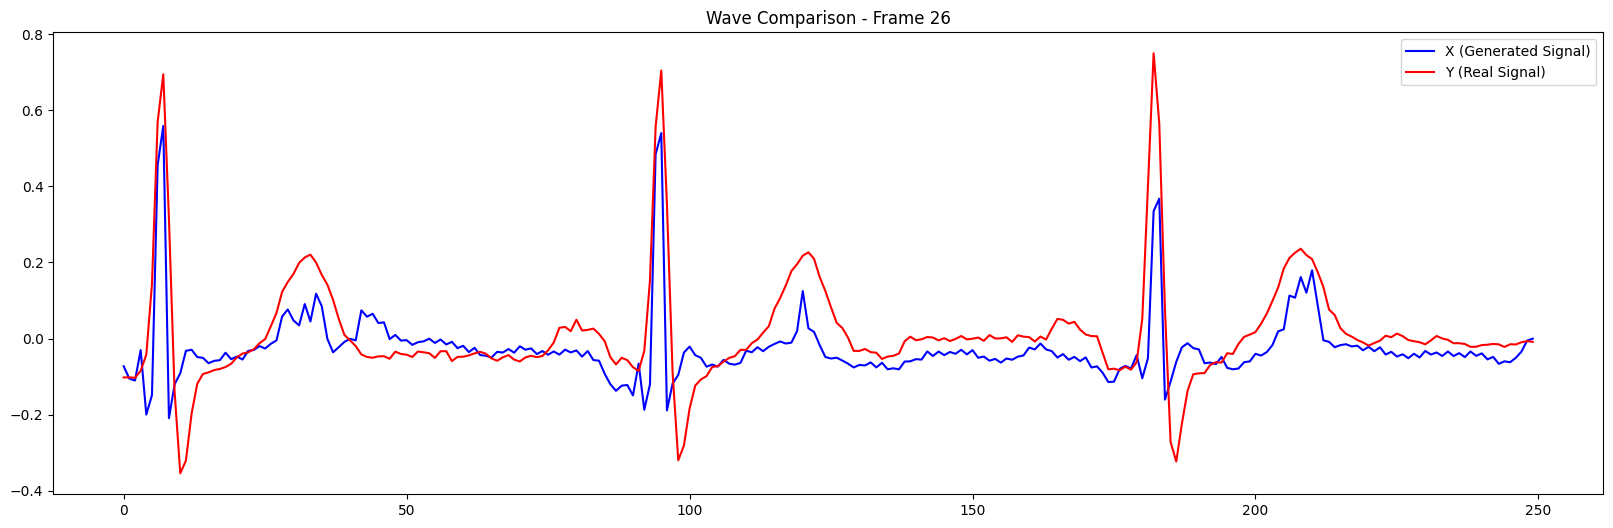

Frame 26:
Mean Squared Error (MSE): 0.0112
Fréchet Distance: 0.1909


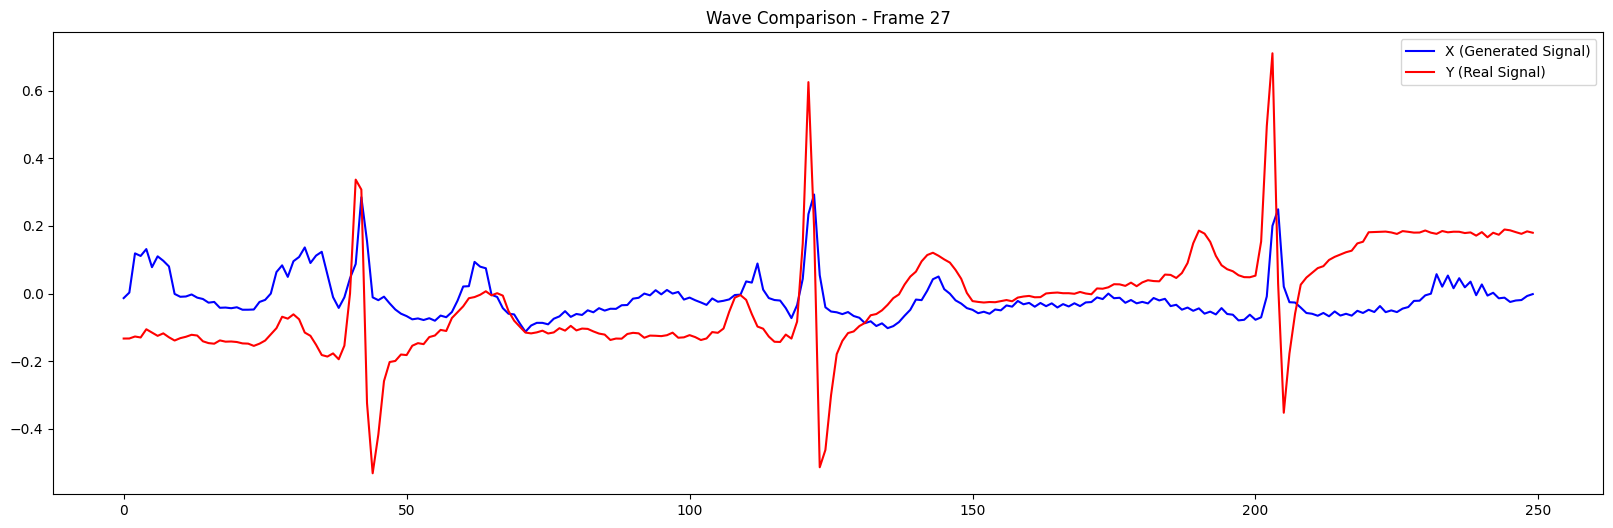

Frame 27:
Mean Squared Error (MSE): 0.0239
Fréchet Distance: 0.4184
Epoch 140/151, Critic Loss: -0.22705605626106262, Generator Loss: 12.661145210266113
Epoch 141/151, Critic Loss: 0.20394766330718994, Generator Loss: 10.393442153930664
Epoch 142/151, Critic Loss: -0.5496240854263306, Generator Loss: 12.294107437133789
Epoch 143/151, Critic Loss: -0.18783751130104065, Generator Loss: 11.253559112548828
Epoch 144/151, Critic Loss: -0.06933591514825821, Generator Loss: 7.534936904907227
Epoch 145/151, Critic Loss: -0.5996929407119751, Generator Loss: 17.21701431274414
Epoch 146/151, Critic Loss: -0.022485610097646713, Generator Loss: 10.678733825683594
Epoch 147/151, Critic Loss: 0.05700518935918808, Generator Loss: 18.232566833496094
Epoch 148/151, Critic Loss: -0.45277920365333557, Generator Loss: 13.859869956970215
Epoch 149/151, Critic Loss: 0.0971226766705513, Generator Loss: 8.513740539550781


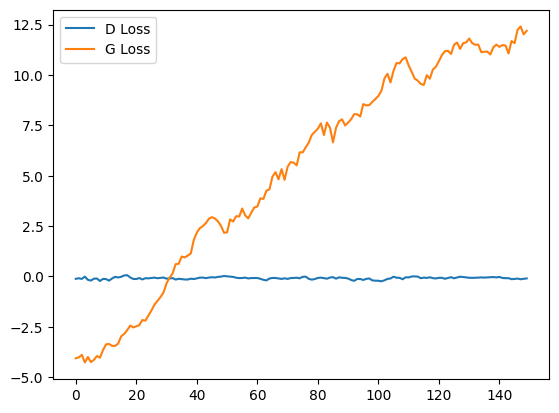

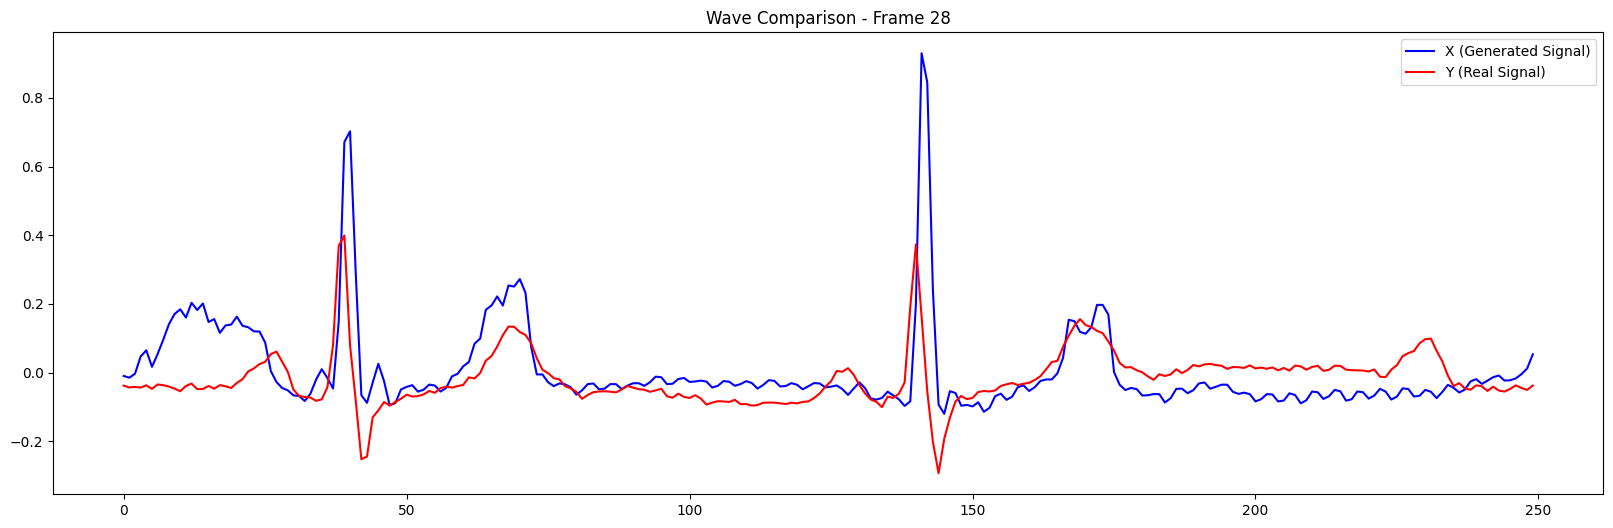

Frame 28:
Mean Squared Error (MSE): 0.0158
Fréchet Distance: 0.5305


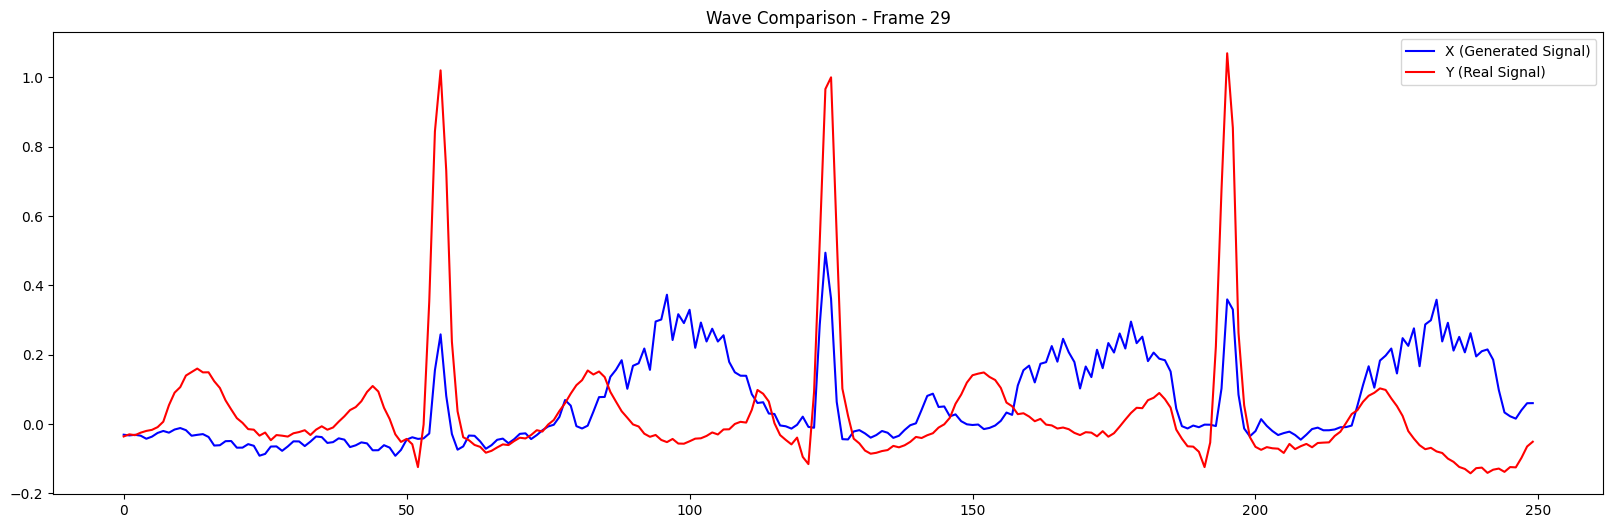

Frame 29:
Mean Squared Error (MSE): 0.0382
Fréchet Distance: 0.5752
Epoch 150/151, Critic Loss: 0.04737481474876404, Generator Loss: 13.749587059020996
Epoch 151/151, Critic Loss: 0.1347341388463974, Generator Loss: 12.751519203186035


In [17]:
g_losses, d_losses = [], []
for epoch in range(epochs):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(device=device, dtype=torch.float32), real_2.to(device=device, dtype=torch.float32)
        real_2 += 0.01 * torch.randn_like(real_2) #ADDING SOME NOISE
        for _ in range(3):
            optimizer_c.zero_grad()
            noise = torch.randn_like(real_1)
            gen_input = torch.stack([real_1, noise], dim=1)  # (batch, 2, seq_len)
            
            fake_2 = generator(gen_input)
            d_real_input = torch.cat([real_2.unsqueeze(1), real_1.unsqueeze(1)], dim=1)
            d_fake_input = torch.cat([fake_2.detach(), real_1.unsqueeze(1)], dim=1)

            real_scores = critic(d_real_input)
            fake_scores = critic(d_fake_input)  # Detach to avoid generator update
            #gradient_penalty
            
            gradient_penalty = compute_gradient_penalty(critic, real_2.unsqueeze(1), fake_2.detach(), real_1.unsqueeze(1), device)    
            c_loss = torch.mean(fake_scores) - torch.mean(real_scores) + 10*gradient_penalty
            c_loss.backward()
            optimizer_c.step()
            
            # # Clip critic weights
            # for p in critic.parameters():
            #     p.data.clamp_(-clip_value, clip_value)
        
        optimizer_g.zero_grad()
        gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1)
        fake_2 = generator(gen_input)
        d_fake_input = torch.cat([fake_2, real_1.unsqueeze(1)], dim=1)
        g_loss = -torch.mean(critic(d_fake_input))
        g_loss.backward()
        optimizer_g.step()
    g_losses.append(g_loss.item())
    d_losses.append(c_loss.item())
    if (epoch+1)%10==0:
        plot_losses(d_losses, g_losses)
        with torch.no_grad():
            for real_1, real_2 in dataloader:   
                real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
                real_1, real_2 = real_1.to(device), real_2.to(device)
                gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1) 
                fake_2 = generator(gen_input)
                counter = plotWave(fake_2[0],real_2[0], counter)
                counter = plotWave(fake_2[12],real_2[12], counter) #random output
                break
    print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {c_loss.item()}, Generator Loss: {g_loss.item()}")


In [ ]:
# #ONLY c-GAN training loop
# criterion = nn.BCELoss()
# g_losses, d_losses = [], []
# for epoch in range(epochs):
#     for real_1, real_2 in dataloader:
#         real_1, real_2 = real_1.to(device=device, dtype=torch.float32), real_2.to(device=device, dtype=torch.float32)
#         #real_2 += 0.01 * torch.randn_like(real_2)  # Noise augmentation
#         # Train Discriminator
#         optimizer_d.zero_grad()
#         # Generate noise and condition
        
#         noise = torch.randn_like(real_1)
#         gen_input = torch.stack([real_1, noise], dim=1)  # (batch, 2, seq_len)
#         fake_2 = generator(gen_input)
#         # Real and fake inputs for discriminator
#         d_real_input = torch.cat([real_2.unsqueeze(1), real_1.unsqueeze(1)], dim=1)
#         d_fake_input = torch.cat([fake_2.detach(), real_1.unsqueeze(1)], dim=1)

#         # Discriminator loss
#         real_labels = torch.ones(real_1.size(0), 1, device=device)
#         fake_labels = torch.zeros(real_1.size(0), 1, device=device)
#         d_real_loss = criterion(discriminator(d_real_input), real_labels)
#         d_fake_loss = criterion(discriminator(d_fake_input), fake_labels)
#         d_loss = (d_real_loss + d_fake_loss)/2
#         d_loss.backward()
#         optimizer_d.step()

#         # Train Generator
#         optimizer_g.zero_grad()
#         gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1)
#         fake_2 = generator(gen_input)
#         d_fake_input = torch.cat([fake_2, real_1.unsqueeze(1)], dim=1)
#         g_loss = 0.9*criterion(discriminator(d_fake_input), real_labels)  + 0.1 * l1_loss(fake_2, real_2)
#         g_loss.backward()
#         optimizer_g.step()
#     g_losses.append(g_loss.item())
#     d_losses.append(d_loss.item())
#     if (epoch+1)%50==0:
#         plot_losses(d_losses, g_losses)
#         with torch.no_grad():
#             for real_1, real_2 in dataloader:   
#                 real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
#                 real_1, real_2 = real_1.to(device), real_2.to(device)
#                 gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1) 
#                 fake_2 = generator(gen_input)
#                 counter = plotWave(fake_2[0],real_2[0], counter)
#                 counter = plotWave(fake_2[12],real_2[12], counter) #random output
#                 break
#     print(f"Epoch {epoch+1}/{epochs}, Discrimiator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}")

Epoch 1/151, Discrimiator Loss: 0.3402656018733978, Generator Loss: 2.1275439262390137
Epoch 2/151, Discrimiator Loss: 0.08739927411079407, Generator Loss: 6.106816291809082


KeyboardInterrupt: 

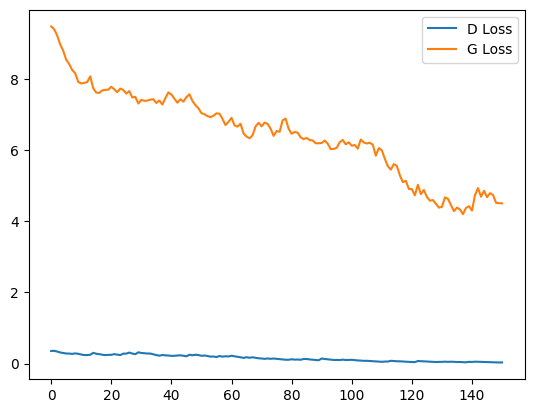

In [ ]:
g_losses_new = []
for l in g_losses:
    g_losses_new.append(10.0-l)
plot_losses(d_losses, g_losses_new)

In [ ]:
#save model
torch.save(generator.state_dict(), 'generator-STFT-7.pth')

In [ ]:
def get_metrics(ecg_tensors, fs=100):
    rr = []
    qrs = []
    qt = []
    st = []
    ecg_tensors = ecg_tensors.view(32, 250)
    for ecg_tensor in ecg_tensors:
        ecg_tensor = torch.concat([ecg_tensor, ecg_tensor], dim=0)
        ecg_np = ecg_tensor.detach().cpu().squeeze().numpy()
        
        if len(ecg_np) < 500:
            raise ValueError("ECG length too short. Needs at least 500 samples (~5s at 100Hz).")

        _, info = nk.ecg_process(ecg_np, sampling_rate=fs)

        r_peaks = list(info.get("ECG_R_Peaks", []))
        q_peaks = list(info.get("ECG_Q_Peaks", []))
        s_peaks = list(info.get("ECG_S_Peaks", []))
        t_onsets = list(info.get("ECG_T_Onsets", []))
        t_offsets = list(info.get("ECG_T_Offsets", []))
        while r_peaks and r_peaks[-1] > 250:
            r_peaks.pop()
        while q_peaks and q_peaks[-1] > 250:
            q_peaks.pop()
        while s_peaks and s_peaks[-1] > 250:
            s_peaks.pop()
        while t_onsets and t_onsets[-1] > 250:
            t_onsets.pop()
        while t_offsets and t_offsets[-1] > 250:
            t_offsets.pop()
        rr_intervals = np.diff(r_peaks) / fs if len(r_peaks) >= 2 else []
        qrs_durations = [(s - q) / fs for q, s in zip(q_peaks, s_peaks)] if q_peaks and s_peaks else []
        qt_intervals = [(to - q) / fs for q, to in zip(q_peaks, t_offsets)] if q_peaks and t_offsets else []
        st_intervals = [(t - s) / fs for s, t in zip(s_peaks, t_onsets)] if s_peaks and t_onsets else []
        for x in rr_intervals:
            if not np.isnan(x) and x > 0:
                rr.append(x)
        for x in qrs_durations:
            if not np.isnan(x) and x > 0:
                qrs.append(x)
        for x in qt_intervals:
            if not np.isnan(x) and x > 0:
                qt.append(x)
        for x in st_intervals:
            if not np.isnan(x) and x > 0:
                st.append(x)
    return {
        "RR_intervals": np.mean(rr) if rr else [],
        "QRS_durations": np.mean(qrs) if qrs else [],
        "QT_intervals": np.mean(qt) if qt else [],
        "ST_intervals": np.mean(st) if st else []
    }


In [ ]:
get_metrics(fake_2, fs=100)

/Users/pratyushgaurav/Documents/BiometricByPass/.venv/lib/python3.13/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


ValueError: cannot convert float NaN to integer

(torch.Size([32, 1, 250]), torch.Size([32, 250]))

{'RR_intervals': np.float64(0.8613725490196077), 'QRS_durations': np.float64(0.1127848101265823), 'QT_intervals': np.float64(0.34524999999999995), 'ST_intervals': np.float64(0.12779220779220776)} {'RR_intervals': np.float64(0.8020370370370371), 'QRS_durations': np.float64(0.1278048780487805), 'QT_intervals': np.float64(0.35473684210526324), 'ST_intervals': np.float64(0.12723684210526318)}


ValueError: The truth value of an empty array is ambiguous. Use `array.size > 0` to check that an array is not empty.

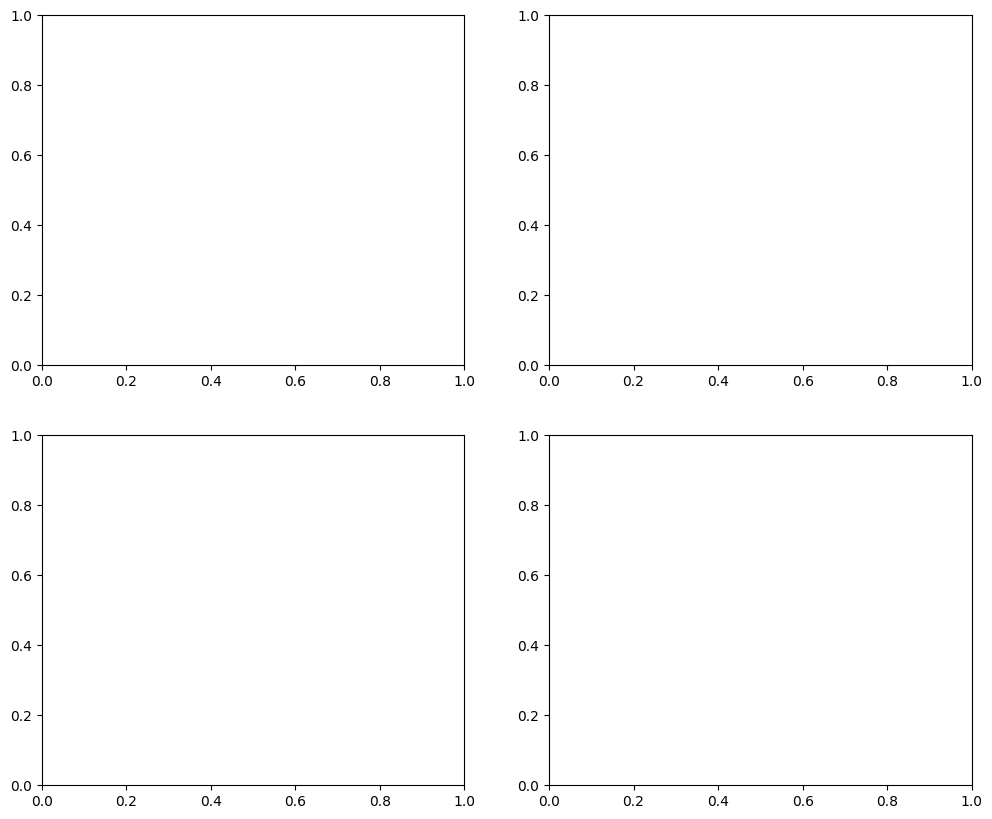

In [ ]:

def bland_altman_plot(data1, data2, title="Bland-Altman Plot", ylabel="Difference", ax=None):
    data1 = np.array(data1)
    data2 = np.array(data2)
    means = (data1 + data2) / 2
    diffs = data1 - data2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(means, diffs, alpha=0.6)
    ax.axhline(mean_diff, color='gray', linestyle='--', label='Mean Diff')
    ax.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', label='+1.96 SD')
    ax.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', label='-1.96 SD')
    ax.set_title(title)
    ax.set_xlabel('Mean of Real and Fake')
    ax.set_ylabel(ylabel)
    ax.legend()
    return ax

fake_metrics = get_metrics(fake_2, fs=100)
real_metrics = get_metrics(real_2, fs=100)

keys = ["RR_intervals", "QRS_durations", "QT_intervals", "ST_intervals"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

print(fake_metrics, real_metrics)

for i, key in enumerate(keys):
    fake_val = fake_metrics[key]
    real_val = real_metrics[key]
    if fake_val != [] and real_val != []:
        bland_altman_plot([real_val], [fake_val], title=f"{key} - Bland-Altman", ylabel=f"{key} Diff", ax=axs[i])
    else:
        axs[i].text(0.5, 0.5, 'Insufficient Data', ha='center', va='center')
        axs[i].set_title(f"{key} - Bland-Altman")
        axs[i].axis('off')

plt.tight_layout()
plt.show()
